# Pulse wave classification in 7 classes（Undergraduate Design）
2022.4.10  author: Loki Xun

---
## 数据预处理
- 统一采样率
- 分片

## 时域：波形时序数据分类
- Bi-Lstm
- Transformer

## 频域：提取 MFCC、Fbank 特征
- 使用 CNN 分类

## 特征融合：Two-stream CNN 方式




In [1]:
from google.colab import drive #挂载云端硬盘
drive.mount('/content/drive')

Mounted at /content/drive


### 将数据集存到分配到机器上

In [2]:
!mkdir ./data_xrj
# !cp -r /content/drive/MyDrive/Pulse_7_Classification/seven_pulse2018/Fbank_666_840x280/ ./data_xrj
# !rm -rf /content/data_xrj/

In [ ]:
# 网盘文件压缩
def zip_directory(source_dir_path, target_zip_path):
    import zipfile
    import os
    from pathlib import Path

    assert os.path.exists(source_dir_path), f"source={source_dir_path} not exists!"
    with zipfile.ZipFile(target_zip_path, "a") as zipfp:
        for parent_dir, _, filename_list in os.walk(source_dir_path):
            for origin_filename in filename_list:
                origin_filepath_tmp = Path(parent_dir).joinpath(origin_filename)
                zipfp.write(origin_filepath_tmp.as_posix(),origin_filepath_tmp.name)
    print(f"source_dir_path={source_dir_path}, target_zip_path={target_zip_path} 压缩完成！")

In [3]:
# 查看分配到的 GPU 资源是否为 P100
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Wed May 25 01:54:13 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
!pip install python_speech_features

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for python-speech-features: filename=python_speech_features-0.6-py3-none-any.whl size=5888 sha256=47307e8e8324bc3fe273ae25df271599c5ce1d5ca126f7914e434d565923ccb5
  Stored in directory: /root/.cache/pip/wheels/b0/0e/94/28cd6afa3cd5998a63eef99fe31777acd7d758f59cf24839eb
Successfully built python-speech-features


In [5]:
import os
import re
from pathlib import Path
import random
from typing import Tuple, Union, Dict, List
import math
import time

import numpy as np
from matplotlib import pyplot as plt
from scipy.fftpack import dct
from scipy.signal import spectrogram
from scipy.signal import resample_poly, butter, filtfilt, medfilt
from python_speech_features import mfcc, delta, fbank
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras import Model
# 显存设置
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
# GPU 设置
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" #保证程序中的GPU序号和硬件中的序号相同
os.environ['CUDA_VISIBLE_DEVICES'] = '0' #设置 -1 使用 CPU 训练

# #  TensorFlow程序会默认占用显卡中的所有显存，设置按需求动态增长
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)


pulse_class_name_list = ["滑脉", "平脉", "实脉", "细脉", "细弦脉", "弦滑脉", "弦脉"]  # 下标对应 class_no
base_path = Path("/content/drive/MyDrive/Pulse_7_Classification").resolve()
assert os.path.exists(base_path), "base_path loading failed!"
pulse_dataset_dir = base_path.joinpath("seven_pulse2018")
print(f"base_path={base_path}")
feature_result_dir = base_path.joinpath("feature_result")

base_path=/content/drive/MyDrive/Pulse_7_Classification


# 数据预处理
## data_preprocessing.py 数据预处理、频域特征提取

In [6]:
class PulsePreprocessing:
    def __init__(self):
        self._test_num_each_class = 5

    @staticmethod
    def detrend_sigle_wave_data(wave_data_array, current_sample_rate=666) -> np.ndarray:
        """
        去除基线漂移: 基线漂移是一种低频噪声成分, 频率通常小于1Hz, 使用巴特沃斯高通过滤
        :param wave_data_array:
        :param current_sample_rate:
        :return:
        """
        assert len(wave_data_array.shape) == 2, f"wave_data_array shape={wave_data_array.shape} not match!"
        start_time = time.time()

        #  1. 0.5-50Hz 四阶巴特沃斯带通过滤器
        LOW_CUT = 0.5
        HIGH_CUT = 100
        fn = 0.5 * current_sample_rate  # 最大频率
        f_low = LOW_CUT / fn
        f_high = HIGH_CUT / fn

        method_name = f"{LOW_CUT}Hz-{HIGH_CUT}Hz bandpass"
        freq_window = [f_low, f_high]
        b, a = butter(N=4, Wn=freq_window, btype="bandpass")
        filtered_signal = filtfilt(b, a, wave_data_array)
        # print(f"filtered_signal.shape={filtered_signal.shape}， filtered_signal={filtered_signal}")

        # # 2. 1Hz 巴特沃斯高通
        # method_name = f"{LOW_CUT}Hz HighPass"
        # freq_window = f_low
        # b, a = butter(N=4, Wn=freq_window, btype="highpass")
        # filtered_signal = filtfilt(b, a, wave_data_array)
        # # print(f"filtered_signal.shape={filtered_signal.shape}， filtered_signal={filtered_signal}")

        return filtered_signal

    @staticmethod
    def get_wave_peak_bottom_index(wave_data_array, current_sample_rate=666):
        # TODO: pip install biosppy
        assert len(wave_data_array.shape) == 2, f"shape not match"
        # peak_result = ecg.christov_segmenter(wave_data_array[0,], sampling_rate=current_sample_rate)
        # rpeaks_result = peak_result['rpeaks']
        # # get bottom
        # peak_result = ecg.christov_segmenter(wave_data_array[0,] * (-1), sampling_rate=current_sample_rate)
        # bottom_result = peak_result['rpeaks']
        # return rpeaks_result, bottom_result

    @staticmethod
    def copy_file_to_another_dir(source_path, save_path) -> Tuple[bool, str]:
        try:
            if not Path(source_path).is_file():
                raise Exception(f"原始文件不存在！source_path={source_path}")

            shutil.copy(source_path, save_path)
            return True, save_path

        except Exception as e:
            state_message = f"转移文件失败！message={str(e)}"
            logger.exception(state_message)
            return False, state_message

    @staticmethod
    def plot_wave_data(origin_pulse_array, downsampled_pulse_array, time_len: int):
        plt.figure()
        plt.subplot(2, 1, 1)
        plt.plot(origin_pulse_array, 'r-')
        plt.title(f"origin freq={origin_pulse_array.shape[0] / time_len} Hz")
        plt.subplot(2, 1, 2)
        plt.plot(downsampled_pulse_array, "b-")
        plt.title(f"downsample freq={downsampled_pulse_array.shape[0] / time_len} Hz")
        plt.grid(which="minor", linestyle='-.', axis='both')
        plt.show()

    @staticmethod
    def save_npy_file(pulse_data_dict, save_filename="train_test_data.npz"):
        save_path = pulse_dataset_dir.joinpath(save_filename).as_posix()
        np.savez(save_path, pulse_data=pulse_data_dict)
        print(f"保存npz 文件成功！save_path={save_path}")

    @staticmethod
    def load_npy_saved_pulse_data(npz_save_path: str) -> Dict[int, Dict[str, List[dict]]]:
        """
        load from npz file
            Pulse data description: In total 988 pulse samples, pulse's time info={'60.0s': 899, '6.0s': 89}: pulse data
           have 2 kinds of times info. And pulse data have sparse pressure info.
        :param npz_save_path:
        :return: pulse data dict-> Dict[ key=class->int, value=Dict[key in ('test','train'), value= signle_data_dict] ]
            single_data_dict=Dict['t':int, 'p':float, 'data':numpy array]
        """
        npz_result = np.load(npz_save_path, allow_pickle=True)
        pulse_all_class_data_dict = npz_result['pulse_data'].item()
        return pulse_all_class_data_dict

    @staticmethod
    def load_one_txt_data(data_filepath: str) -> Tuple[bool, Union[str, dict]]:
        """
        读取 txt 波形数据到 pandas.DataFrame
        :param data_filepath: 读取 txt 文件中数据
        :return: Dict[ 't': 秒数->float, 'p': 压力值->float, "data":时序波形数据->ndarray, 'filepath': str]
        """
        try:
            pulse_wave_data_list = []
            with open(data_filepath, "r+") as fp:
                for line_no, data_str in enumerate(fp.readlines()):
                    data_str = data_str.replace("\n", "")
                    if line_no == 0:
                        t_pulse, p_pulse = re.findall(r"\d+.\d*", data_str)[:2]
                    else:
                        pulse_wave_data_list.append(eval(data_str))

            return True, {"t": t_pulse, "p": p_pulse, "data": np.array([pulse_wave_data_list]),
                          'filepath': Path(data_filepath).name}
        except Exception as e:
            logger.exception(f"load_one_txt_data Failed! data_filepath={data_filepath}")
            return False, str(e)

    def split_origin_train_test_data(self) -> Tuple[bool, Union[dict, str]]:
        """
        分割 train、test 数据，存入字典，保存 npy 文件
        :return: data dict-> Dict[class_label, Dict[test:[], train:[]] ]
        """
        pulse_data_dict = {}
        for class_name in os.listdir(pulse_all_data_path.as_posix()):
            class_label = pulse_class_name_list.index(class_name)
            print(f"class={class_name}, class_label={class_label}")
            if class_name not in pulse_class_name_list:
                raise Exception(f"unsupported class type!class_name={class_name}")

            class_dir_path = pulse_all_data_path.joinpath(class_name)
            class_data_path_list = [class_dir_path.joinpath(item_filename).as_posix()
                                    for item_filename in os.listdir(class_dir_path.as_posix())]
            if not class_data_path_list:
                raise Exception(f"class={class_name} with empty data!")
            # 0. shuffle sequence
            random.seed(1)  # 设置随机种子，使得每次运行结果可复现
            random.shuffle(class_data_path_list)
            # 1. split train test
            test_filename_list = class_data_path_list[:self._test_num_each_class]
            train_filename_list = class_data_path_list[self._test_num_each_class:]

            # 2. extract data
            pulse_data_dict[class_label] = {"train": [], "test": []}
            for data_filepath in test_filename_list:
                success_flag, data_info_result = \
                    self.load_one_txt_data(data_filepath=data_filepath)
                if not success_flag:
                    raise Exception(data_info_result)
                pulse_data_dict[class_label]["test"].append(data_info_result)

            for data_filepath in train_filename_list:
                success_flag, data_info_result = \
                    self.load_one_txt_data(data_filepath=data_filepath)
                if not success_flag:
                    raise Exception(data_info_result)
                pulse_data_dict[class_label]["train"].append(data_info_result)

            logger.info(f"class={class_name}, label={class_label}: train_test_split success!"
                        f"train_num={len(train_filename_list)}, test_num={len(test_filename_list)}")
        # save npy file
        self.save_npy_file(pulse_data_dict)
        print(f"train_test_split finish!")
        return True, pulse_data_dict

    @staticmethod
    def downsample_pulse_data(wave_data_array, origin_time_length, target_sample_rate):
        """对数据进行重采样"""
        assert isinstance(wave_data_array, np.ndarray) and len(wave_data_array.shape) == 2
        # 1. 均匀采样
        time_index_list = np.linspace(start=0, stop=wave_data_array.shape[1],
                                      num=math.ceil(origin_time_length * target_sample_rate), endpoint=False, dtype=int)
        # downsampled_data = wave_data_array[:, time_index_list]
        # print(f"shape={wave_data_array.shape},wave_data_list={wave_data_array}")
        # print(f"shape={wave_data_array.shape}, time_index_list={time_index_list}")
        # print(f"shape={downsampled_data.shape}, downsampled_data={downsampled_data}, type={type(downsampled_data)}")

        # 1.2 np.interp
        downsampled_data = np.interp(time_index_list, np.arange(0, wave_data_array.shape[1]), wave_data_array[0])
        downsampled_data = downsampled_data.reshape((1, downsampled_data.shape[0]))
        print(f"wave_data_list={wave_data_array}, shape={wave_data_array.shape}")
        print(f"downsampled_data={downsampled_data}, shape={downsampled_data.shape}")

        # # 2. scipy signal
        # current_sample_rate = int(wave_data_array.shape[1] / origin_time_length)
        # downsampled_data = resample_poly(wave_data_array[0, :], up=target_sample_rate, down=current_sample_rate)
        # downsampled_data = downsampled_data.reshape((1, downsampled_data.shape[0]))
        # print(f"shape={wave_data_array.shape},wave_data_list={wave_data_array}")
        # print(f"shape={downsampled_data.shape}, downsampled_data={downsampled_data}, type={type(downsampled_data)}")

        return downsampled_data

    def unify_sample_rate(self, pulse_all_class_data_dict, target_sample_rate=666):
        """
        统一sample rate, 全部降采样到 666 Hz （采样率的最小值）
        :param pulse_all_class_data_dict:
        :param target_sample_rate:
        :return:
        """
        for class_no in pulse_all_class_data_dict:
            for type_str in ["train", "test"]:
                for data_index in range(len(pulse_all_class_data_dict[class_no][type_str])):
                    data_info_dict = pulse_all_class_data_dict[class_no][type_str][data_index]
                    wave_data_array = data_info_dict['data']
                    down_sample_data = self.downsample_pulse_data(wave_data_array=data_info_dict["data"],
                                                                  origin_time_length=eval(data_info_dict['t']),
                                                                  target_sample_rate=target_sample_rate)
                    pulse_all_class_data_dict[class_no][type_str][data_index]["data"] = down_sample_data
                    # self.plot_wave_data(wave_data_array[0,], down_sample_data[0,], time_len=eval(data_info_dict['t']))

            print(f"class_no={class_no} 降采样完成！")
        return pulse_all_class_data_dict

    @staticmethod
    def get_train_test_data_slice(pulse_all_data_dict, frame_length=600, frame_step=350):
        """
        对原始时序数据按 步长、帧移 分片，获取模型输入 x_train, y_train
        :param pulse_all_data_dict: Dict[class_no->int, key=Dict[key in ('train','test'), value=List[data_info_dict]] ]
            data_info_dict -> Dict['t'->str, 'p'->str, 'data'->np.ndarray(shape=(1,n))]
        :param frame_length:
        :param frame_step:
        :return: x_train->np.ndarray , shape= (n, frame_length), y_train->np.ndarray, shape=(n,1)
        """
        train_data_dict = {"x_train": [], "y_train": [], "x_test": [], "y_test": []}
        # 帧移调整参数，提前求出
        class_frame_step_dict = {6: int(frame_step/0.36), 5: int(frame_step/0.81), 4: int(frame_step/1.2),
                                 3: int(frame_step / 5), 2: int(frame_step / 3), 1: int(frame_step / 4), 0: int(frame_step / 1.7)}
        # class_frame_step_dict = {6: min(frame_length,frame_length-100), 5: frame_step, 4: frame_step,
        #                          3: int(frame_step / 5), 2: int(frame_step / 3), 1: frame_step, 0: frame_step}
        origin_frame_step=frame_step
        for class_no in pulse_all_data_dict:
            for data_type_str in ["train", "test"]:
                # 少数类,增加分片数, 多数类减少分片数
                frame_step = class_frame_step_dict[class_no] if data_type_str=="train" else origin_frame_step

                for data_info_dict in pulse_all_data_dict[class_no][data_type_str]:
                    # 分片
                    wave_data_array = data_info_dict["data"][0,]  # 原始 shape=(1,n)
                    signal_length = len(wave_data_array)
                    num_frames = int(
                        np.ceil(np.abs(signal_length - frame_length) / frame_step)) + 1
                    pad_signal_length = (num_frames - 1) * frame_step + frame_length
                    z = np.zeros((pad_signal_length - signal_length))
                    # 分帧后最后一帧点数不足，则补零
                    # 获取帧：frames 是二维数组，每一行是一帧，列数是每帧的采样点数，之后的短时 fft 直接在每一列上操作
                    pad_signal = np.append(wave_data_array, z)
                    indices = np.arange(0, frame_length).reshape(
                        1, -1) + np.arange(0, num_frames * frame_step, frame_step).reshape(-1, 1)
                    frames = pad_signal[indices]

                    # add to x_train, y_train
                    train_data_dict[f"x_{data_type_str}"].extend(frames.tolist())
                    train_data_dict[f"y_{data_type_str}"].extend([int(class_no)] * frames.shape[0])

                print(f"class_no={class_no}, data_type_str={data_type_str} 分片完成！")

        x_train = np.array(train_data_dict["x_train"])
        y_train = np.array(train_data_dict["y_train"]).reshape((-1, 1))
        x_test = np.array(train_data_dict["x_test"])
        y_test = np.array(train_data_dict["y_test"]).reshape((-1, 1))

        print(f"x_train shape={x_train.shape}")
        print(f"y_train shape={y_train.shape}")
        print(f"x_test shape={x_test.shape}")
        print(f"y_test shape={y_test.shape}")

        return x_train, y_train, x_test, y_test

    def detrend_wave_data(self, pulse_all_data_dict):
        for class_no in pulse_all_data_dict:
            for type_str in ["train", "test"]:
                for data_index in range(len(pulse_all_data_dict[class_no][type_str])):
                    data_info_dict = pulse_all_data_dict[class_no][type_str][data_index]
                    current_sample_rate = int(data_info_dict["data"].shape[1] / eval(data_info_dict['t']))
                    detrend_wave_data = self.detrend_sigle_wave_data(data_info_dict["data"],
                                                                     current_sample_rate=current_sample_rate)
                    pulse_all_data_dict[class_no][type_str][data_index]["data"] = detrend_wave_data

            print(f"class_no={class_no} 去基线漂移完成！")
        return pulse_all_data_dict

    
class PulseFeature:
    def __init__(self):
        pass

    @staticmethod
    def standardize_wave_data(wave_data):
        wave_mean = np.mean(wave_data, axis=1)
        wave_std = np.std(wave_data, axis=1)
        return (wave_data - wave_mean) / wave_std

    @staticmethod
    def plot_spectrogram(spec, save_path):
        fig = plt.figure(figsize=(20, 5))
        heatmap = plt.pcolor(spec)
        fig.colorbar(mappable=heatmap)
        plt.xlabel('Frames')
        # tight_layout 会自动调整子图参数，使之填充整个图像区域
        # plt.tight_layout()
        plt.title(save_path.stem)
        plt.savefig(save_path)
        plt.show()

    @staticmethod
    def get_scipy_spectrogram(wave_data, sample_rate, frame_size=0.025, frame_stride=0.01, filename=""):
        freq_array, time_segment, Spectrogram_x = spectrogram(x=wave_data[0, :], fs=sample_rate)
        plt.figure(1)
        plt.pcolormesh(time_segment, freq_array, Spectrogram_x, shading="gouraud")
        plt.ylabel('Frequency [Hz]')
        plt.xlabel('Time [sec]')
        plt.show()

    @staticmethod
    def get_frames(wave_data, sample_rate, frame_size=0.025, frame_stride=0.01):
        """
        预加重, 分帧, 幅值归一化
        :param wave_data: ndarray, shape=(1,n)
        :param sample_rate: 采样率
        :param frame_size: 帧长 默认 25 ms
        :param frame_stride: 帧移 默认 10 ms
        :return:
        """
        # 1. 预加重: 补偿高频部分振幅
        pre_emphasis = 0.97
        emphasized_signal = np.append(
            wave_data[0, 0], wave_data[:, 1:] - pre_emphasis * wave_data[:, -1])

        # 2. 分帧
        frame_length, frame_step = int(
            round(frame_size * sample_rate)), int(round(frame_stride * sample_rate))
        signal_length = len(emphasized_signal)
        num_frames = int(
            np.ceil(np.abs(signal_length - frame_length) / frame_step)) + 1
        pad_signal_length = (num_frames - 1) * frame_step + frame_length
        z = np.zeros((pad_signal_length - signal_length))
        # 分帧后最后一帧点数不足，则补零
        # 获取帧：frames 是二维数组，每一行是一帧，列数是每帧的采样点数，之后的短时 fft 直接在每一列上操作
        pad_signal = np.append(emphasized_signal, z)
        indices = np.arange(0, frame_length).reshape(
            1, -1) + np.arange(0, num_frames * frame_step, frame_step).reshape(-1, 1)
        frames = pad_signal[indices]
        print("shape of frames:", frames.shape)

        # 3. 加 hamming 窗
        frames *= np.hamming(frame_length)
        return frames

    def save_fbank_mfcc_feature(self, wave_data, sample_rate, frame_size=0.025, frame_stride=0.01, save_name=""):
        """
        提取 Fbank、MFCC 特征: 自己编写的
        :param wave_data:
        :param sample_rate:
        :param frame_size:
        :param frame_stride:
        :param save_name:
        :return:
        """
        # 分帧, 加窗
        frames = self.get_frames(wave_data=wave_data, sample_rate=sample_rate,
                                 frame_size=frame_size, frame_stride=frame_stride)
        print(f"frames shape={frames.shape}, {frames}")
        # FFT
        NFFT = 512  # 频谱系数的点数
        mag_frames = np.absolute(np.fft.rfft(frames, NFFT))  # 频谱幅值
        pow_frames = ((1.0 / NFFT) * (mag_frames ** 2))  # 能量频谱
        print(f"FFT result: pow_frames shape={pow_frames.shape}, pow_frames={pow_frames}")

        # Fbank
        low_freq_mel = 0
        high_freq_mel = 2595 * np.log10(1 + (sample_rate / 2) / 700)
        # mel 滤波器中心点：为了方便后面计算 mel 滤波器组，左右两边各补一个中心点
        nfilt = 200  # Mel 滤波器个数
        mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)

        hz_points = 700 * (10 ** (mel_points / 2595) - 1)
        fbank = np.zeros((nfilt, int(NFFT / 2 + 1)))  # 各个 mel 滤波器在能量谱对应点的取值
        bin = (hz_points / (sample_rate / 2)) * \
              (NFFT / 2)  # 各个 mel 滤波器中心点对应 FFT 的区域编码，找到有值的位置
        # 计算 mel 滤波器函数: 矩阵运算更快
        for i in range(1, nfilt + 1):
            left = int(bin[i - 1])
            center = int(bin[i])
            right = int(bin[i + 1])
            for j in range(left, center):
                fbank[i - 1, j + 1] = (j + 1 - bin[i - 1]) / (bin[i] - bin[i - 1])
            for j in range(center, right):
                fbank[i - 1, j + 1] = (bin[i + 1] - (j + 1)) / (bin[i + 1] - bin[i])
                # print(fbank)
        filter_banks = np.dot(pow_frames, fbank.T)
        filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)
        filter_banks = 20 * np.log10(filter_banks)  # dB
        # print(filter_banks)
        print("shape of FBank", filter_banks.shape)
        print(f"filter_banks={filter_banks}")
        self.plot_spectrogram(filter_banks.T, feature_result_dir.joinpath(f"Fbank_{save_name}"))

        # MFCC
        num_ceps = 12  # 保留的倒谱系数的个数
        mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')  # shape of MFCC=(570 帧数, 200 滤波器个数)
        mfcc_feature_result = mfcc[:, 1:(num_ceps + 1)]  # 选取 2-13 维度
        print(f"shape of MFCC={mfcc.shape}, mfcc={mfcc}")
        self.plot_spectrogram(mfcc_feature_result.T, feature_result_dir.joinpath(f"MFCC_{save_name}"))

        # Normalization
        filter_banks -= (np.mean(filter_banks, axis=0) + 1e-8)
        self.plot_spectrogram(filter_banks.T, feature_result_dir.joinpath(f"Fbank_normalized_{save_name}"))
        mfcc_feature_result -= (np.mean(mfcc_feature_result, axis=0) + 1e-8)
        self.plot_spectrogram(mfcc_feature_result.T, feature_result_dir.joinpath(f"MFCC_normalized_{save_name}"))

    @staticmethod
    def get_dynamic_mfcc_matrix(wave_data, sample_rate, mfcc_normalization=False,
                                winlen=0.025, winstep=0.01, numcep=13, nfilt=200, winfunc=np.hamming):
        """
        第三方开源模块 python_speech_features, 提取 动态 mfcc 特征： 静态+一、二阶差分
        :param wave_data:
        :param sample_rate:
        :param mfcc_normalization:
        :param winlen:
        :param winstep:
        :param numcep:
        :param nfilt:
        :param winfunc:
        :return:
        """
        assert isinstance(wave_data, np.ndarray) and len(wave_data.shape) == 2, f"wave_data 格式错误！"

        mfcc_feature_result = mfcc(signal=wave_data.T, samplerate=sample_rate, winlen=winlen, winstep=winstep,
                                   numcep=numcep, nfilt=nfilt, winfunc=winfunc)
        # print(f"mfcc: static feature result={mfcc_feature_result.shape}, {mfcc_feature_result}")

        # 动态特征：计算一阶、二阶差分, 对每个特征向量进行延长（1*13-> 1*39)
        d_mfcc_feat = delta(mfcc_feature_result, 1)  # 每行为一个特征向量
        d_mfcc_feat2 = delta(mfcc_feature_result, 2)
        mfcc_final_result = np.hstack((mfcc_feature_result, d_mfcc_feat, d_mfcc_feat2))

        # MFCC, Fbank features: normalization
        if mfcc_normalization:
            mfcc_final_result -= (np.mean(mfcc_final_result, axis=0) + 1e-8)

        return mfcc_final_result

    @staticmethod
    def get_fbank_matrix(wave_data, sample_rate, winlen=0.025, winstep=0.01, nfilt=200, winfunc=np.hamming):
        """
        第三方开源模块 python_speech_features, 提取 fbank 特征
        :param wave_data:
        :param sample_rate:
        :param winlen:
        :param winstep:
        :param nfilt:
        :param winfunc:
        :return:
        """
        assert isinstance(wave_data, np.ndarray) and len(wave_data.shape) == 2, f"wave_data 格式错误！"

        fbank_result, energy_each_frame = fbank(signal=wave_data.T, samplerate=sample_rate, winlen=winlen,
                                                winstep=winstep,
                                                nfilt=nfilt, winfunc=winfunc)  # 未取对数
        return np.log(fbank_result)

    def get_train_test_data_mfcc_feature(self, x_data, sample_rate=666.0, numcep=20):
        """
        每片序列数据转换为 mfcc 或 fbank 矩阵
        :param x_data:
        :param get_dynamic_mfcc_matrix_func:
        :param sample_rate:
        :param numcep:
        :return:
        """
        assert isinstance(x_data, np.ndarray) and len(x_data.shape) == 2

        mfcc_feature_data = []
        for data_index in range(x_data.shape[0]):
            wave_data_array = np.reshape(x_data[data_index, :], (1, -1))
            freq_feature_result = self.get_dynamic_mfcc_matrix(wave_data=wave_data_array, sample_rate=sample_rate,
                                                               numcep=numcep)
            mfcc_feature_data.append(freq_feature_result)

        mfcc_feature_data = np.array(mfcc_feature_data, dtype=np.float32)
        return mfcc_feature_data

    def get_train_test_data_fbank_feature(self, x_data, sample_rate=666.0):
        """
        每片序列数据转换为 mfcc 或 fbank 矩阵
        :param x_data:
        :param sample_rate:
        :return:
        """
        assert isinstance(x_data, np.ndarray) and len(x_data.shape) == 2

        fbank_feature_data = []
        for data_index in range(x_data.shape[0]):
            wave_data_array = np.reshape(x_data[data_index, :], (1, -1))
            freq_feature_result = self.get_fbank_matrix(wave_data=wave_data_array, sample_rate=sample_rate)
            fbank_feature_data.append(freq_feature_result)
            if int(data_index // x_data.shape[0]) > 0 and int(data_index % 20) == 0:
                print(f"fbank 特征转换: No.{data_index}/{x_data.shape[0]}")

        fbank_feature_data = np.array(fbank_feature_data, dtype=np.float16)
        return fbank_feature_data
    
    def convert_save_fbank_feature(self, x_data, y_data, fbank_save_dir_path: str,
                                   sample_rate=666.0, filename_prefix="x_train") \
            -> Tuple[bool, list]:
        """
        每片序列数据转换为 fbank 矩阵 , 单独存储为 npy 文件
        :param x_data:
        :param y_data
        :param fbank_save_dir_path
        :param sample_rate:
        :param filename_prefix:
        :return: 返回文件路径列表
        """
        assert isinstance(x_data, np.ndarray) and len(x_data.shape) == 2
        assert x_data.shape[0] == y_data.shape[0]
        fbank_save_dir_path = Path(fbank_save_dir_path)
        assert fbank_save_dir_path.exists(), f"Fbank 保存路径不存在！{fbank_save_dir_path}"

        start_time = time.time()
        fbank_data_path_list = []
        for data_index in range(x_data.shape[0]):
            wave_data_array = np.reshape(x_data[data_index, :], (1, -1))
            freq_feature_result = self.get_fbank_matrix(wave_data=wave_data_array, sample_rate=sample_rate)
            # save npy file
            fbank_save_name = f"{filename_prefix}_{data_index}_{int(y_data[data_index, 0])}"
            fbank_save_path = fbank_save_dir_path.joinpath(fbank_save_name).as_posix()
            np.save(fbank_save_path, freq_feature_result)
            fbank_data_path_list.append(fbank_save_path)

            if data_index % 3000 == 0:
                print(f"{filename_prefix} 存储 Fbank 特征：No.{data_index}/{x_data.shape[0]} costs={int(time.time()-start_time)/60}min")

        return True, fbank_data_path_list

# 读取数据

## 数据分片
- 根据指定帧长、帧移, 分片
- x_train, x_test 转换为 MFCC, Fbank 矩阵

In [51]:
# 读取数据信息
import math
import time
pulse_preprocess = PulsePreprocessing()
downsampled_npz_filename = "downsampled_train_test_dict.npz"
sample_rate = 666.0  # 统一的采样率
npz_save_path_str = pulse_dataset_dir.joinpath(downsampled_npz_filename).as_posix()
assert Path(npz_save_path_str).is_file(), f"文件不存在, filepath={npz_save_path_str}"
pulse_all_class_data_dict = pulse_preprocess.load_npy_saved_pulse_data(npz_save_path=npz_save_path_str)

# 去基线漂移+去噪
start_time=time.time()
pulse_all_class_data_dict = pulse_preprocess.detrend_wave_data(pulse_all_class_data_dict)
print(f"去噪+去基线漂移完成！costs={time.time()-start_time}s")

# 切片
start_time = time.time()
heart_beat_average_seconds = 1.2 # 按平均一次心跳的秒数分片
# frame_length = math.ceil(heart_beat_average_seconds * sample_rate)+40  # 840
# frame_step = 280  # int(frame_length/3)
frame_length = math.ceil(heart_beat_average_seconds * sample_rate)*3  # 2400
frame_step = 350  # int(frame_length/3)
freq_frame_length = min(frame_length, 840)
print(f"frame_length={frame_length},freq_frame_length={freq_frame_length}")


x_train, y_train, x_test, y_test = PulsePreprocessing.get_train_test_data_slice(
    pulse_all_class_data_dict,frame_length=frame_length,frame_step=frame_step)
print(f"get data slices costs={time.time() - start_time}s")  # 9s

class_no=2 去基线漂移完成！
class_no=1 去基线漂移完成！
class_no=5 去基线漂移完成！
class_no=6 去基线漂移完成！
class_no=0 去基线漂移完成！
class_no=4 去基线漂移完成！
class_no=3 去基线漂移完成！
去噪+去基线漂移完成！costs=1.6804587841033936s
frame_length=2400,freq_frame_length=840
class_no=2, data_type_str=train 分片完成！
class_no=2, data_type_str=test 分片完成！
class_no=1, data_type_str=train 分片完成！
class_no=1, data_type_str=test 分片完成！
class_no=5, data_type_str=train 分片完成！
class_no=5, data_type_str=test 分片完成！
class_no=6, data_type_str=train 分片完成！
class_no=6, data_type_str=test 分片完成！
class_no=0, data_type_str=train 分片完成！
class_no=0, data_type_str=test 分片完成！
class_no=4, data_type_str=train 分片完成！
class_no=4, data_type_str=test 分片完成！
class_no=3, data_type_str=train 分片完成！
class_no=3, data_type_str=test 分片完成！
x_train shape=(108128, 2400)
y_train shape=(108128, 1)
x_test shape=(3712, 2400)
y_test shape=(3712, 1)
get data slices costs=36.47000312805176s


In [ ]:
# # 计算需要 20000 个分片，每个类需要多大帧移
# needed_clips_num = 20000
# frame_strp_dict={}
# for class_no in pulse_all_class_data_dict:
#   data_len_list=[item["data"].shape[1] for item in pulse_all_class_data_dict[class_no]["train"]]
#   proper_frame_step = (sum(data_len_list) - frame_length * len(data_len_list))/(needed_clips_num-len(data_len_list))
#   frame_strp_dict[class_no]=proper_frame_step
# print(frame_strp_dict)


In [ ]:
# 检查每一类分片数
# 原始脉诊样本
class_data_info_dict={class_no:(len(pulse_all_class_data_dict[class_no]["train"]),len(pulse_all_class_data_dict[class_no]["test"])) for class_no in pulse_all_class_data_dict}
print(class_data_info_dict)

# train、test、validate 中的各类分布
train_distribution_dict={class_no:np.sum(y_train==class_no) for class_no in class_data_info_dict}
print(f"y_train distribution:{train_distribution_dict}")
train_distribution_dict={class_no:np.sum(y_test==class_no) for class_no in class_data_info_dict}
print(f"y_test distribution:{train_distribution_dict}")

{2: (54, 5), 1: (39, 5), 5: (188, 5), 6: (435, 5), 0: (92, 5), 4: (117, 5), 3: (28, 5)}
y_train distribution:{2: 16930, 1: 14822, 5: 15382, 6: 15291, 0: 15436, 4: 15203, 3: 15064}
y_test distribution:{2: 545, 1: 545, 5: 442, 6: 545, 0: 545, 4: 545, 3: 545}


In [ ]:
# 查看分片长度是否合适
def show_slice_effect(x_array, y_array, show_num=50):
    """检查分片长度是否合适"""
    show_num = min(show_num, x_array.shape[0])
    columns_num = 5
    ros_num = int(show_num / columns_num)
    plt.figure(figsize=(15, 5 * ros_num))
    for i in range(show_num):
        plt.subplot(ros_num, columns_num, i + 1)
        plt.plot(x_array[i, :])
        plt.title(f"class={y_array[i,]}")
    plt.show()
show_slice_effect(x_test[3000:,], y_test[3000:,])

## 准备 2 个stream 数据
###  频域分类：转换为 MFCC、Fbank 特征，使用 CNN 网络分类（保存npy文件）下标与时域数据对应，通过 Datagenerator 导入
- 训练数据预处理

In [8]:
# 转换为 MFCC、Fbank 特征
pulse_feature = PulseFeature()
# # 1. 获取 MFCC 特征
# start_time = time.time()
# x_train = pulse_feature.get_train_test_data_mfcc_feature(x_data=x_train,
#                                                                       sample_rate=sample_rate, numcep=20)
# print(f"mfcc_feature_x_train: mfcc 特征转换成功！costs={(time.time() - start_time)/60}min")
# x_test = pulse_feature.get_train_test_data_mfcc_feature(x_data=x_test,
#                                                                      sample_rate=sample_rate, numcep=20)
# print(f"mfcc_feature_x_train shape={x_train.shape}, "
#       f"mfcc_feature_x_test shape={x_test.shape}, costs={(time.time() - start_time)/60}min")
# mfcc_pulse_data_dict = {"x_train": x_train, "y_train": y_train,
#                         "x_test": x_test, "y_test": y_test}
# mfcc_pulse_data_npz_filename = f"MFCC_{sample_rate}_{frame_length}x{frame_step}_detrend_balance-1.npz"
# # 保存 npz 文件
# pulse_preprocess.save_npy_file(pulse_data_dict=mfcc_pulse_data_dict, save_filename=mfcc_pulse_data_npz_filename)
# del mfcc_pulse_data_dict

# # -------读取 MFCC 保存的数据(读取的每个 mfcc shape=119x60) 要加一维！
# mfcc_pulse_data_npz_filename = "MFCC_666.0_840x280_detrend_balance-1.npz"  # "MFCC_666.0_840x280.npz"
# data_save_path = pulse_dataset_dir.joinpath(mfcc_pulse_data_npz_filename).as_posix()
# mfcc_pulse_data_dict = PulsePreprocessing.load_npy_saved_pulse_data(data_save_path)
# x_train, y_train, x_test, y_test = mfcc_pulse_data_dict["x_train"], mfcc_pulse_data_dict["y_train"], \
#                                    mfcc_pulse_data_dict["x_test"], mfcc_pulse_data_dict["y_test"]
# del mfcc_pulse_data_dict
# x_train = np.reshape(x_train, (*x_train.shape, 1))  # 增加一维
# x_test = np.reshape(x_test, (*x_test.shape, 1))


# 2. 获取 Fbank 特征
pulse_feature = PulseFeature()
start_time = time.time()
fbank_data_name = f"Fbank_{int(sample_rate)}_{freq_frame_length}x{frame_step}"
# # fbank_save_dir = pulse_dataset_dir.joinpath(fbank_data_name)
fbank_save_dir = Path("./data_xrj").resolve().joinpath(fbank_data_name)
fbank_save_dir.mkdir(exist_ok=True, parents=True)
print(f"fbank_save_dir={fbank_save_dir} 提取 fbank 特征并存储")

_, x_train_path_list = pulse_feature.convert_save_fbank_feature(x_train[:,:freq_frame_length], y_train,
                                 fbank_save_dir_path=fbank_save_dir,
                                 sample_rate=sample_rate,
                                 filename_prefix="train"
                                 )
print(f"fbank_feature_x_train: fbank 特征转换成功！costs={time.time() - start_time}s")
_, x_test_path_list = pulse_feature.convert_save_fbank_feature(x_test[:,:freq_frame_length], y_test,
                                 fbank_save_dir_path=fbank_save_dir,
                                 sample_rate=sample_rate,
                                 filename_prefix="test"
                                 )
print(f"fbank_feature_x_test: fbank 特征转换成功！total costs={time.time() - start_time}s")
fbank_pulse_data_dict = {"x_train_path_list": x_train_path_list, "y_train": y_train,
                          "x_test_path_list": x_test_path_list, "y_test": y_test}
pulse_preprocess.save_npy_file(pulse_data_dict=fbank_pulse_data_dict, save_filename=f"{fbank_data_name}_pathlist")
del fbank_pulse_data_dict

# # 读取 Fbank 保存的数据 （保存的是npy文件路径列表，之后需要加通道！）
# fbank_pulse_data_npz_filename = "Fbank_666_840x350_pathlist.npz"
# data_save_path = pulse_dataset_dir.joinpath(fbank_pulse_data_npz_filename).as_posix()
# fbank_data_name = f"Fbank_666_840x350"
# # fbank_save_dir = pulse_dataset_dir.joinpath(fbank_data_name)

# fbank_pulse_data_dict = PulsePreprocessing.load_npy_saved_pulse_data(data_save_path)
# x_train_path_list, y_train, x_test_path_list, y_test = fbank_pulse_data_dict["x_train_path_list"], fbank_pulse_data_dict["y_train"], \
#                                    fbank_pulse_data_dict["x_test_path_list"], fbank_pulse_data_dict["y_test"]
# del fbank_pulse_data_dict
x_train_path_list = np.array([x_train_path_list]).T
x_test_path_list = np.array([x_test_path_list]).T

# # test 上测试
# _, x_test_path_list = pulse_feature.convert_save_fbank_feature(x_test[:,:freq_frame_length], y_test,
#                                  fbank_save_dir_path=fbank_save_dir,
#                                  sample_rate=sample_rate,
#                                  filename_prefix="test"
#                                  )
# x_test_path_list = np.array([x_test_path_list]).T

# 打乱数据集
np.random.seed(7)
np.random.shuffle(x_train_path_list)
np.random.seed(7)
np.random.shuffle(y_train)
tf.random.set_seed(7)

fbank_save_dir=/content/data_xrj/Fbank_666_840x350 提取 fbank 特征并存储
train 存储 Fbank 特征：No.0/108128 costs=0.0min
train 存储 Fbank 特征：No.3000/108128 costs=0.3min
train 存储 Fbank 特征：No.6000/108128 costs=0.6166666666666667min
train 存储 Fbank 特征：No.9000/108128 costs=0.9333333333333333min
train 存储 Fbank 特征：No.12000/108128 costs=1.2333333333333334min
train 存储 Fbank 特征：No.15000/108128 costs=1.55min
train 存储 Fbank 特征：No.18000/108128 costs=1.8666666666666667min
train 存储 Fbank 特征：No.21000/108128 costs=2.183333333333333min
train 存储 Fbank 特征：No.24000/108128 costs=2.5min
train 存储 Fbank 特征：No.27000/108128 costs=2.8min
train 存储 Fbank 特征：No.30000/108128 costs=3.1166666666666667min
train 存储 Fbank 特征：No.33000/108128 costs=3.433333333333333min
train 存储 Fbank 特征：No.36000/108128 costs=3.75min
train 存储 Fbank 特征：No.39000/108128 costs=4.066666666666666min
train 存储 Fbank 特征：No.42000/108128 costs=4.383333333333334min
train 存储 Fbank 特征：No.45000/108128 costs=4.7min
train 存储 Fbank 特征：No.48000/108128 costs=5.03333333333333

In [ ]:
# a=np.load("/content/data_xrj/Fbank_666_840x350/test_2037_6.npy", allow_pickle=True)
# print(a.shape)

(119, 200)


## 时域数据: reshape 到 RNN 输入格式

In [9]:
# 调整输入大小
# 1. RNN: 改变 shape 匹配 RNN 输入格式 【输入样本的组数, 时间步（想要几个输入后再有个输出）, 每个时刻输入循环核的特征个数】
time_step = 40  # 40x60
feature_num_each_step = int(x_train.shape[1] / time_step)
assert int(x_train.shape[1] % time_step) == 0, f"RNN input error！sample len={x_train.shape[1]}, time_step={time_step}"
x_train_time = np.reshape(x_train, (x_train.shape[0], time_step, feature_num_each_step))
x_test_time = np.reshape(x_test, (x_test.shape[0], time_step, feature_num_each_step))

# 打乱数据集
np.random.seed(7)
np.random.shuffle(x_train_time)
tf.random.set_seed(7)

In [10]:
# 分割 train、validation set
# assert len(x_train.shape)==4, f"x_train shape={x_train.shape} 没有增加一维！"
print(f"origin x_train.shape={x_train.shape}, y_train.shape={y_train.shape}")

train_num = int(x_train_path_list.shape[0]*0.9)
x_validate_freq = x_train_path_list[train_num:,:]
x_validate_time = x_train_time[train_num:,:]
y_validate = y_train[train_num:,:]

x_train_freq = x_train_path_list[0:train_num,:]
x_train_time = x_train_time[0:train_num,:]
y_train = y_train[0:train_num,:]


print(f"x_train_path_list={x_train_path_list.shape},")
print(f"x_validate_freq={x_validate_freq.shape},x_validate_time={x_validate_time.shape}")
print(f"x_train_freq={x_train_freq.shape}, x_train_time={x_train_time.shape}")
print(f"y_train={y_train.shape},y_validate={y_validate.shape}")

print(y_train[:10])  # 检查是否已经打乱

origin x_train.shape=(108128, 2400), y_train.shape=(108128, 1)
x_train_path_list=(108128, 1),
x_validate_freq=(10813, 1),x_validate_time=(10813, 40, 60)
x_train_freq=(97315, 1), x_train_time=(97315, 40, 60)
y_train=(97315, 1),y_validate=(10813, 1)
[[5]
 [3]
 [3]
 [2]
 [3]
 [1]
 [6]
 [3]
 [0]
 [3]]


In [52]:
print(f"x_train_path_list={x_train_path_list.shape},")
print(f"x_validate_freq={x_validate_freq.shape},x_validate_time={x_validate_time.shape},y_validate={y_validate.shape}")
print(f"x_train_freq={x_train_freq.shape}, x_train_time={x_train_time.shape},y_train={y_train.shape}")
print(x_test_path_list.shape, y_test.shape)

x_train_path_list=(108128, 1),
x_validate_freq=(10813, 1),x_validate_time=(10813, 40, 60),y_validate=(10813, 1)
x_train_freq=(97315, 1), x_train_time=(97315, 40, 60),y_train=(108128, 1)
(3712, 1) (3712, 1)


In [12]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, x_path_array, y_data_array, x_time_data_array,
                 batch_size=64, shuffle=True, feature_save_dir_path=""):
        self.x_path_array = x_path_array  # npy 文件路径 array
        self.y_data_array = y_data_array
        self.x_time_data_array = x_time_data_array
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.index_array = np.arange(len(self.x_path_array))
        self.feature_save_dir = Path(feature_save_dir_path)
        self.on_epoch_end()

    def __len__(self):
        return math.ceil(len(self.x_path_array) / self.batch_size)

    def __getitem__(self, idx):
        # Generate indexes of the batch
        indexes = self.index_array[idx * self.batch_size: (idx + 1) * self.batch_size]
        # Find list of IDs
        y_data_return = self.y_data_array[indexes, :]
        x_path_list_temp = [self.x_path_array[k, :] for k in indexes]  # 取出一部分数据
        x_time_data_return = np.array([self.x_time_data_array[k,:] for k in indexes])
        # 读取本地 fbank 文件
        x_data_return = self.__load_batch_x_data_from_file(x_path_list_temp)
        if len(x_data_return.shape)!=4:
          x_data_return = np.reshape(x_data_return, (*x_data_return.shape, 1))
        # print(f"x_data_return shape={x_data_return.shape}")
        return [x_time_data_return, x_data_return], y_data_return

    def on_epoch_end(self):
        self.index_array = np.arange(len(self.x_path_array))
        if self.shuffle:
            np.random.shuffle(self.index_array)

    def __load_batch_x_data_from_file(self, x_path_list) -> np.ndarray:
        """读取本地文件，生成 batch data（ndarray）"""
        x_return_array = []
        for idx in range(len(x_path_list)):
          npy_name = Path(x_path_list[idx][0]).name  # avoid saved as absolute path
          x_data_save_path = self.feature_save_dir.joinpath(f"{npy_name}.npy").as_posix()
          x_data = np.load(x_data_save_path)
          x_return_array.append(x_data)

        return np.array(x_return_array)



# two-stream model

## CBAM 模块

In [13]:
import keras.backend as K
import keras.layers as KL
from tensorflow.keras.layers import Reshape

# 判断输入数据格式，是channels_first还是channels_last
channel_axis = 1  if K.image_data_format() == "channels_first" else 3

# CAM
def channel_attention(input_xs, reduction_ratio=0.125):
    # get channel
    channel = int(input_xs.shape[channel_axis])
    maxpool_channel = KL.GlobalMaxPooling2D()(input_xs)
    maxpool_channel = KL.Reshape((1, 1, channel))(maxpool_channel)
    avgpool_channel = KL.GlobalAvgPool2D()(input_xs)
    avgpool_channel = KL.Reshape((1, 1, channel))(avgpool_channel)
    Dense_One = KL.Dense(units=int(channel * reduction_ratio), activation='relu', kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')
    Dense_Two = KL.Dense(units=int(channel), activation='relu', kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')
    # max path
    mlp_1_max = Dense_One(maxpool_channel)
    mlp_2_max = Dense_Two(mlp_1_max)
    mlp_2_max = KL.Reshape(target_shape=(1, 1, int(channel)))(mlp_2_max)
    # avg path
    mlp_1_avg = Dense_One(avgpool_channel)
    mlp_2_avg = Dense_Two(mlp_1_avg)
    mlp_2_avg = KL.Reshape(target_shape=(1, 1, int(channel)))(mlp_2_avg)
    channel_attention_feature = KL.Add()([mlp_2_max, mlp_2_avg])
    channel_attention_feature = KL.Activation('sigmoid')(channel_attention_feature)
    return KL.Multiply()([channel_attention_feature, input_xs])

# SAM
def spatial_attention(channel_refined_feature):
    maxpool_spatial = KL.Lambda(lambda x: K.max(x, axis=3, keepdims=True))(channel_refined_feature)
    avgpool_spatial = KL.Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(channel_refined_feature)
    max_avg_pool_spatial = KL.Concatenate(axis=3)([maxpool_spatial, avgpool_spatial])
    return KL.Conv2D(filters=1, kernel_size=(3, 3), padding="same", activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(max_avg_pool_spatial)


def cbam_module(input_xs, reduction_ratio=0.25):
    channel_refined_feature = channel_attention(input_xs, reduction_ratio=reduction_ratio)
    print(channel_refined_feature.shape)
    spatial_attention_feature = spatial_attention(channel_refined_feature)
    refined_feature = KL.Multiply()([channel_refined_feature, spatial_attention_feature])
    return KL.Add()([refined_feature, input_xs])

from tensorflow.keras.layers import GlobalAvgPool2D, GlobalMaxPooling2D, Reshape, Dense, Add, Activation, Multiply, \
    Concatenate

class CbamModule(Model):
    def __init__(self, channel, reduction_ratio=16):
        super(CbamModule, self).__init__()
        self.reduction_ratio = reduction_ratio
        # CAM
        self.cam_maxpool = GlobalMaxPooling2D(name="cbam_maxPool")
        self.cam_avgpool = GlobalAvgPool2D(name="cbam_avgPool")
        self.Dense_One = Dense(units=int(channel//reduction_ratio), activation='relu', kernel_initializer='he_normal',
                               use_bias=True, bias_initializer='zeros', name="cbam_dense1")
        self.Dense_Two = Dense(units=int(channel), activation='relu', kernel_initializer='he_normal', use_bias=True,
                               bias_initializer='zeros', name="cbam_dense2")
        self.add = Add()
        self.sigmoid_activation = Activation('sigmoid')
        self.multiply = Multiply()
        # SAM
        self.sam_concate = Concatenate(axis=3)
        self.sam_conv2d = Conv2D(filters=1, kernel_size=(7, 7), strides=1, padding='same', name="same_Conv2D_7x7")

    def call(self, input_xs):
        # 1. CAM
        maxpool_channel = self.cam_maxpool(input_xs)
        avgpool_channel = self.cam_avgpool(input_xs)
        # max path
        mlp_1_max = self.Dense_One(maxpool_channel)
        mlp_2_max = self.Dense_Two(mlp_1_max)
        # avg path
        mlp_1_avg = self.Dense_One(avgpool_channel)
        mlp_2_avg = self.Dense_Two(mlp_1_avg)
        channel_attention_feature = self.add([mlp_2_max, mlp_2_avg])
        channel_attention_feature = self.sigmoid_activation(channel_attention_feature)
        channel_refined_feature = self.multiply([channel_attention_feature, input_xs])

        # 2. SAM
        maxpool_spatial = tf.reduce_mean(channel_refined_feature, axis=3, keepdims=True, name="SAM_avgPool")
        avgpool_spatial = tf.reduce_max(channel_refined_feature, axis=3, keepdims=True, name="SAM_avgPool")
        max_avg_pool_spatial = self.sam_concate([maxpool_spatial, avgpool_spatial])
        spatial_attention_feature = self.sam_conv2d(max_avg_pool_spatial)
        spatial_attention_feature = self.sigmoid_activation(spatial_attention_feature)

        # CBAM output
        cbam_output = self.multiply([channel_refined_feature, spatial_attention_feature])
        return self.add([cbam_output, input_xs])



## ResNet 50/101/152

In [14]:
from tensorflow.keras import layers, Model, Sequential


class BasicBlock(layers.Layer):
    expansion = 1

    def __init__(self, out_channel, strides=1, downsample=None, **kwargs):
        super(BasicBlock, self).__init__(**kwargs)
        self.conv1 = layers.Conv2D(out_channel, kernel_size=3, strides=strides,
                                   padding="SAME", use_bias=False)
        self.bn1 = layers.BatchNormalization(momentum=0.9, epsilon=1e-5)
        # -----------------------------------------
        self.conv2 = layers.Conv2D(out_channel, kernel_size=3, strides=1,
                                   padding="SAME", use_bias=False)
        self.bn2 = layers.BatchNormalization(momentum=0.9, epsilon=1e-5)
        # -----------------------------------------
        self.downsample = downsample
        self.relu = layers.ReLU()
        self.add = layers.Add()

    def call(self, inputs, training=False):
        identity = inputs
        if self.downsample is not None:
            identity = self.downsample(inputs)

        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x, training=training)

        x = self.add([identity, x])
        x = self.relu(x)

        return x


class Bottleneck(layers.Layer):
    """
    注意：原论文中，在虚线残差结构的主分支上，第一个1x1卷积层的步距是2，第二个3x3卷积层步距是1。
    但在pytorch官方实现过程中是第一个1x1卷积层的步距是1，第二个3x3卷积层步距是2，
    这么做的好处是能够在top1上提升大概0.5%的准确率。
    可参考Resnet v1.5 https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch
    """
    expansion = 4

    def __init__(self, out_channel, strides=1, downsample=None, **kwargs):
        super(Bottleneck, self).__init__(**kwargs)
        self.conv1 = layers.Conv2D(out_channel, kernel_size=1, use_bias=False, name="conv1")
        self.bn1 = layers.BatchNormalization(momentum=0.9, epsilon=1e-5, name="conv1/BatchNorm")
        # -----------------------------------------
        self.conv2 = layers.Conv2D(out_channel, kernel_size=3, use_bias=False,
                                   strides=strides, padding="SAME", name="conv2")
        self.bn2 = layers.BatchNormalization(momentum=0.9, epsilon=1e-5, name="conv2/BatchNorm")
        # -----------------------------------------
        self.conv3 = layers.Conv2D(out_channel * self.expansion, kernel_size=1, use_bias=False, name="conv3")
        self.bn3 = layers.BatchNormalization(momentum=0.9, epsilon=1e-5, name="conv3/BatchNorm")
        # -----------------------------------------
        self.relu = layers.ReLU()
        self.downsample = downsample
        self.add = layers.Add()
        # CBAM
        self.cbam_layer = CbamModule(out_channel * self.expansion)

    def call(self, inputs, training=True):
        identity = inputs
        if self.downsample is not None:
            identity = self.downsample(inputs)

        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x, training=training)
        x = self.relu(x)

        x = self.conv3(x)
        x = self.bn3(x, training=training)
        # # CBAM: imitate SENet 
        # x = self.cbam_layer(x)

        x = self.add([x, identity])
        x = self.relu(x)
        # # CBAM
        # x = self.cbam_layer(x)

        return x


def _make_layer(block, in_channel, channel, block_num, name, strides=1):
    """ downsample 为残差结构
    in_channel 用于区分 ResNetBlock 还是 Bottleneck Block
    strides != 1 区分第几个 Block，第一个block"""
    downsample = None
    if strides != 1 or in_channel != channel * block.expansion:
        downsample = Sequential([
            layers.Conv2D(channel * block.expansion, kernel_size=1, strides=strides,
                          use_bias=False, name="conv1"),
            layers.BatchNormalization(momentum=0.9, epsilon=1.001e-5, name="BatchNorm")
        ], name="shortcut")

    layers_list = []
    layers_list.append(block(channel, downsample=downsample, strides=strides, name="unit_1"))

    # 每个Block 里面有多个小block, 如果 stride=2 下采样也只是在第一个小block 里面
    for index in range(1, block_num):
        layers_list.append(block(channel, name="unit_" + str(index + 1)))

    return Sequential(layers_list, name=name)


def _resnet(block, blocks_num, im_width=224, im_height=224, im_channel=1, num_classes=1000, include_top=True):
    # tensorflow中的tensor通道排序是NHWC
    # (None, 224, 224, 3)
    input_image = layers.Input(shape=(im_height, im_width, im_channel), dtype="float32")
    x = layers.Conv2D(filters=64, kernel_size=7, strides=2,
                      padding="SAME", use_bias=False, name="conv1")(input_image)
    x = layers.BatchNormalization(momentum=0.9, epsilon=1e-5, name="conv1/BatchNorm")(x)
    x = layers.ReLU()(x)
    x = layers.MaxPool2D(pool_size=3, strides=2, padding="SAME")(x)

    x = _make_layer(block, x.shape[-1], 64, blocks_num[0], name="block1")(x)
    x = _make_layer(block, x.shape[-1], 128, blocks_num[1], strides=2, name="block2")(x)
    x = _make_layer(block, x.shape[-1], 256, blocks_num[2], strides=2, name="block3")(x)
    x = _make_layer(block, x.shape[-1], 512, blocks_num[3], strides=2, name="block4")(x)

    if include_top:
        x = layers.GlobalAvgPool2D()(x)  # pool + flatten
        x = layers.Dense(num_classes, name="logits")(x)
        predict = layers.Softmax()(x)
    else:
        predict = x

    model = Model(inputs=input_image, outputs=predict)

    return model


def resnet34(im_width=224, im_height=224, im_channel=3, num_classes=1000, include_top=True):
    return _resnet(BasicBlock, [3, 4, 6, 3], im_width, im_height, im_channel, num_classes, include_top)


def resnet50(im_width=224, im_height=224, im_channel=3, num_classes=1000, include_top=True):
    return _resnet(Bottleneck, [3, 4, 6, 3], im_width, im_height, im_channel, num_classes, include_top)


def resnet101(im_width=224, im_height=224, im_channel=3, num_classes=1000, include_top=True):
    return _resnet(Bottleneck, [3, 4, 23, 3], im_width, im_height, im_channel, num_classes, include_top)


input_shape = (119, 200)  # height, width
model = resnet50(im_width=input_shape[1], im_height=input_shape[0], im_channel=1, num_classes=7, include_top=True)  # Res50+CBAM

### VGG16
> 注意若使用把 model 实例化语句去掉

In [ ]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Dropout, Flatten, Dense,\
    Bidirectional, LSTM, GRU,    \
    concatenate, Add, Average, Maximum
class VGG16Combine(Model):
    def __init__(self):
        super(VGG16Combine, self).__init__()
        self.c1 = Conv2D(filters=64, kernel_size=(3, 3), padding='same')  # 卷积层1
        self.b1 = BatchNormalization()  # BN层1
        self.a1 = Activation('selu')  # 激活层1
        self.c2 = Conv2D(filters=64, kernel_size=(3, 3), padding='same', )
        self.b2 = BatchNormalization()  # BN层1
        self.a2 = Activation('selu')  # 激活层1
        self.p1 = MaxPool2D(pool_size=(2, 2), strides=2, padding='same')
        self.d1 = Dropout(0.2)  # dropout层

        self.c3 = Conv2D(filters=128, kernel_size=(3, 3), padding='same')
        self.b3 = BatchNormalization()  # BN层1
        self.a3 = Activation('selu')  # 激活层1
        self.c4 = Conv2D(filters=128, kernel_size=(3, 3), padding='same')
        self.b4 = BatchNormalization()  # BN层1
        self.a4 = Activation('selu')  # 激活层1
        self.p2 = MaxPool2D(pool_size=(2, 2), strides=2, padding='same')
        self.d2 = Dropout(0.2)  # dropout层

        self.c5 = Conv2D(filters=256, kernel_size=(3, 3), padding='same')
        self.b5 = BatchNormalization()  # BN层1
        self.a5 = Activation('selu')  # 激活层1
        self.c6 = Conv2D(filters=256, kernel_size=(3, 3), padding='same')
        self.b6 = BatchNormalization()  # BN层1
        self.a6 = Activation('selu')  # 激活层1
        self.c7 = Conv2D(filters=256, kernel_size=(3, 3), padding='same')
        self.b7 = BatchNormalization()
        self.a7 = Activation('selu')
        self.p3 = MaxPool2D(pool_size=(2, 2), strides=2, padding='same')
        self.d3 = Dropout(0.2)

        self.c8 = Conv2D(filters=512, kernel_size=(3, 3), padding='same')
        self.b8 = BatchNormalization()  # BN层1
        self.a8 = Activation('selu')  # 激活层1
        self.c9 = Conv2D(filters=512, kernel_size=(3, 3), padding='same')
        self.b9 = BatchNormalization()  # BN层1
        self.a9 = Activation('selu')  # 激活层1
        self.c10 = Conv2D(filters=512, kernel_size=(3, 3), padding='same')
        self.b10 = BatchNormalization()
        self.a10 = Activation('selu')
        self.p4 = MaxPool2D(pool_size=(2, 2), strides=2, padding='same')
        self.d4 = Dropout(0.2)

        self.c11 = Conv2D(filters=512, kernel_size=(3, 3), padding='same')
        self.b11 = BatchNormalization()  # BN层1
        self.a11 = Activation('selu')  # 激活层1
        self.c12 = Conv2D(filters=512, kernel_size=(3, 3), padding='same')
        self.b12 = BatchNormalization()  # BN层1
        self.a12 = Activation('selu')  # 激活层1
        self.c13 = Conv2D(filters=512, kernel_size=(3, 3), padding='same')
        self.b13 = BatchNormalization()
        self.a13 = Activation('selu')
        self.p5 = MaxPool2D(pool_size=(2, 2), strides=2, padding='same')
        self.d5 = Dropout(0.2)

        self.flatten = Flatten()
        self.f1 = Dense(512, activation='selu')
        self.d6 = Dropout(0.2)
        self.f2 = Dense(512, activation='selu')
        self.d7 = Dropout(0.2)
        self.f3 = Dense(7, activation='softmax')

    def call(self, x):
        x = self.c1(x)
        x = self.b1(x)
        x = self.a1(x)
        x = self.c2(x)
        x = self.b2(x)
        x = self.a2(x)
        x = self.p1(x)
        x = self.d1(x)

        x = self.c3(x)
        x = self.b3(x)
        x = self.a3(x)
        x = self.c4(x)
        x = self.b4(x)
        x = self.a4(x)
        x = self.p2(x)
        x = self.d2(x)

        x = self.c5(x)
        x = self.b5(x)
        x = self.a5(x)
        x = self.c6(x)
        x = self.b6(x)
        x = self.a6(x)
        x = self.c7(x)
        x = self.b7(x)
        x = self.a7(x)
        x = self.p3(x)
        x = self.d3(x)

        x = self.c8(x)
        x = self.b8(x)
        x = self.a8(x)
        x = self.c9(x)
        x = self.b9(x)
        x = self.a9(x)
        x = self.c10(x)
        x = self.b10(x)
        x = self.a10(x)
        x = self.p4(x)
        x = self.d4(x)

        x = self.c11(x)
        x = self.b11(x)
        x = self.a11(x)
        x = self.c12(x)
        x = self.b12(x)
        x = self.a12(x)
        x = self.c13(x)
        x = self.b13(x)
        x = self.a13(x)
        x = self.p5(x)
        x = self.d5(x)

        x = self.flatten(x)
        x = self.f1(x)
        x = self.d6(x)
        x = self.f2(x)
        x = self.d7(x)
        y = self.f3(x)
        return y


time_model = tf.keras.Sequential([
    Bidirectional(LSTM(128, return_sequences=True)),  # 2个循环计算层，因此中间层的循环核需要输出每个时间步的状态信息 ht
    Dropout(0.1),
    Bidirectional(LSTM(256)),
    Dropout(0.1),
    Dense(64, activation='selu'),
    Dropout(0.1),
    Dense(7, activation='softmax')
])

freq_model = VGG16Combine()

## ResNet18

In [ ]:
class ResnetBlock(Model):

    def __init__(self, filters, strides=1, residual_path=False):
        """
        ResNet块，由 2 层卷积组成，其中第 1 层卷积层的 strides 最后输出尺寸是否改变
        :param filters:
        :param strides:
        :param residual_path:
        """
        super(ResnetBlock, self).__init__()
        self.filters = filters
        self.strides = strides
        self.residual_path = residual_path

        self.c1 = Conv2D(filters, (3, 3), strides=strides, padding='same', use_bias=False)
        self.b1 = BatchNormalization()
        self.a1 = Activation('relu')

        self.c2 = Conv2D(filters, (3, 3), strides=1, padding='same', use_bias=False)
        self.b2 = BatchNormalization()

        # residual_path为True时，对输入进行下采样，即用1x1的卷积核做卷积操作，保证x能和F(x)维度相同，顺利相加
        if residual_path:
            self.down_c1 = Conv2D(filters, (1, 1), strides=strides, padding='same', use_bias=False)
            self.down_b1 = BatchNormalization()

        self.a2 = Activation('relu')

    def call(self, inputs):
        residual = inputs  # residual等于输入值本身，即residual=x
        # 将输入通过卷积、BN层、激活层，计算F(x)
        x = self.c1(inputs)
        x = self.b1(x)
        x = self.a1(x)

        x = self.c2(x)
        y = self.b2(x)

        if self.residual_path:
            residual = self.down_c1(inputs)
            residual = self.down_b1(residual)

        out = self.a2(y + residual)  # 最后输出的是两部分的和，即F(x)+x或F(x)+Wx,再过激活函数
        # 矩阵对应元素相加
        return out


class ResNet18(Model):

    def __init__(self, block_list, initial_filters=64):  # block_list表示每个block有几个卷积层
        super(ResNet18, self).__init__()
        self.num_blocks = len(block_list)  # 共有几个block
        self.block_list = block_list
        self.out_filters = initial_filters
        self.c1 = Conv2D(self.out_filters, (3, 3), strides=1, padding='same', use_bias=False)
        self.b1 = BatchNormalization()
        self.a1 = Activation('relu')

        self.blocks = tf.keras.models.Sequential()
        # 构建ResNet网络结构
        for block_id in range(len(block_list)):  # 第几个resnet block
            for layer_id in range(block_list[block_id]):  # 第几个卷积层

                if block_id != 0 and layer_id == 0:  # 对除第一个block以外的每个block的输入进行下采样
                    block = ResnetBlock(self.out_filters, strides=2, residual_path=True)
                else:
                    block = ResnetBlock(self.out_filters, residual_path=False)
                self.blocks.add(block)  # 将构建好的block加入resnet
            self.out_filters *= 2  # 下一个block的卷积核数是上一个block的2倍

        self.p1 = tf.keras.layers.GlobalAveragePooling2D()
        self.f1 = tf.keras.layers.Dense(10, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2())

    def call(self, inputs):
        x = self.c1(inputs)
        x = self.b1(x)
        x = self.a1(x)

        x = self.blocks(x)

        x = self.p1(x)
        y = self.f1(x)
        return y


# model = ResNet18([2, 2, 2, 2])

## CNN-BiLSTM（对比试验）
- RNN 输入只能是 3维 的！【bt, timestep, feature-each-time】

In [ ]:
# # CNN-BiLSTM
# from tensorflow.keras.layers import  Dense, Bidirectional, LSTM, Dropout, \
#   Conv1D, Conv2D, MaxPooling2D, Flatten
# x_train = x_train.reshape((x_train.shape[0],x_train.shape[1],x_train.shape[2]))
# x_test = x_test.reshape((x_test.shape[0],x_test.shape[1],x_test.shape[2]))
# print(f"x_train.shape={x_train.shape}, y_train.shape={y_train.shape},x_validate.shape={x_validate.shape}, y_validate.shape={y_validate.shape}")
# assert len(x_train.shape)==3, "RNN输入维度不匹配！"

# model = tf.keras.Sequential([
#     Conv1D(32, 3, strides=1, name='conv1', use_bias=False),
#     MaxPooling1D(3, padding="same"),
#     Conv1D(64, 3, strides=1, name='conv2', use_bias=False),  
#     MaxPooling1D(3, padding="same"),
#     Conv1D(128, 3, strides=1, name='conv3', use_bias=False),  
#     MaxPooling1D(3, padding="same"),
#     Bidirectional(LSTM(100, return_sequences=True)),  
#     #Dropout(0.1),
#     Bidirectional(LSTM(64)),
#     Dropout(0.1),
#     Flatten(),
#     Dense(7,  activation='softmax')  
# ])

## Two-stream Model

In [42]:
from tensorflow.keras import Model, Input
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import  Dense, Bidirectional, LSTM, Dropout, GRU, \
  Conv1D, MaxPooling1D, Flatten, Reshape, concatenate, Add, Average, Maximum

def two_stream_classifier_late_fusion(time_model, freq_model,freq_input_shape=(119,200,1)):
    time_model_input = Input(shape=(40, 60), name="time_model_input")  # 1x2400 -> 40x60
    freq_model_input = Input(shape=freq_input_shape, name="freq_model_input")  # MFCC 119x60x1
    time_result = time_model(time_model_input)
    freq_result = freq_model(freq_model_input)

    # two_stream_result = Average()([time_result, freq_result])  # two-stream late fusion
    two_stream_result = freq_result  # frequency only
    # two_stream_result = time_result

    network = Model(inputs=[time_model_input, freq_model_input], outputs=two_stream_result, name="two_stream_PulseNet")
    return network


def two_stream_classifier_early_fusion(time_model, freq_model, freq_input_shape=(119,200,1)):
    time_model_input = Input(shape=(40, 60), name="time_model_input")  # 1x2400 -> 40x60
    freq_model_input = Input(shape=freq_input_shape, name="freq_model_input")  # MFCC 119x60x1

    time_result = time_model(time_model_input, training=False)
    freq_result = freq_model(freq_model_input, training=False)
    # shape == (None,7)

    # # 0. 按特征维度扩展
    # combined_result = concatenate([time_result, freq_result])
    # 1. 按通道维度扩展
    time_result = tf.expand_dims(time_result, -1)
    time_result = tf.expand_dims(time_result, -1)
    freq_result = tf.expand_dims(freq_result, -1)
    freq_result = tf.expand_dims(freq_result, -1)
    combined_result = concatenate([time_result, freq_result])
    # print(combined_result.shape)
    # # combined_result = cbam_module(combined_result)
    combined_result = CbamModule(channel=2)(combined_result)
    combined_result = Flatten()(combined_result)
    two_stream_result = Dense(7, activation="softmax")(combined_result)

    network = Model(inputs=[time_model_input, freq_model_input], outputs=two_stream_result, name="two_stream_PulseNet")
    return network

# load weights
model_save_dir=base_path.joinpath("model")
model_save_dir.mkdir(exist_ok=True, parents=True)
# 0. 加载模型
# 单独加载两个分支模型的参数
time_model_name = "BiLSTM-2layer_detrend_balance_TimeDomain_100_666.0_2400x350_best_checkpoint"
# freq_model_name = "VGG16_detrend_balance_MFCC_numcep20_666.0_840x280_best_checkpoint"  # "VGG16_detrend_MFCC_200_666.0_840x280_200epoch_best_checkpoint"
# freq_model_name = "VGG16_detrend_balance_Fbank_120_666.0_840x280_best_checkpoint"
freq_model_name = "ResNet50_detrend_balance_Fbank_40_666.0_840x280_best_checkpoint"
# freq_model_name = "Inception-10_detrend_balance_Fbank_120_666.0_840x280_best_checkpoint"

time_model_path = model_save_dir.joinpath(time_model_name)
freq_model_path = model_save_dir.joinpath(freq_model_name)
assert time_model_path.exists() and freq_model_path.exists(), f"model file not exists"
time_domain_model = load_model(time_model_path)
freq_domain_model = load_model(freq_model_path)
# Fine-tuning: freeze the pretrained layer

# freq_domain_model.summary()
# time_domain_model.summary()

In [44]:
# # 1. early-fusion
# model=two_stream_classifier_early_fusion(time_model=time_domain_model,freq_model=freq_domain_model)

# # unfreeze model
# freezed_trained_save_path = model_save_dir.joinpath("checkpoint_Two-stream-early-fusion_Unfreeze_CBAM_VGG_BiLSTM_freeze_detrend_balance_Fbank_50_666.0_2400x350.ckpt").as_posix()
# checkpoint_Two-stream-early-fusion_Unfreeze_CBAM_VGG_BiLSTM_freeze_detrend_balance_Fbank_50_666.0_2400x350.ckpt
# checkpoint_Two-stream-early-fusion_Unfreeze_detrend_balance_Fbank_25_666.0_2400x350.ckpt
# model.load_weights(freezed_trained_save_path)

# 2. late-fusion
model = two_stream_classifier_late_fusion(time_model=time_domain_model,freq_model=freq_domain_model)
model_name = "ResNet50_detrend_balance_Fbank_40_666.0_840x280_best_checkpoint"

In [45]:
model.summary()

Model: "two_stream_PulseNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 freq_model_input (InputLayer)  [(None, 119, 200, 1  0           []                               
                                )]                                                                
                                                                                                  
 time_model_input (InputLayer)  [(None, 40, 60)]     0           []                               
                                                                                                  
 model_8 (Functional)           (None, 7)            23569223    ['freq_model_input[0][0]']       
                                                                                                  
Total params: 23,569,223
Trainable params: 23,516,103
Non-trainable params: 53,1

In [ ]:
# 训练
import time

epoch_num=50
batch_size=150
train_generator = DataGenerator(x_train_freq,y_train,x_train_time, batch_size=batch_size,feature_save_dir_path=fbank_save_dir.as_posix())
validate_generator = DataGenerator(x_validate_freq,y_validate,x_validate_time, batch_size=batch_size,feature_save_dir_path=fbank_save_dir.as_posix())

feature_data_name = "Fbank"  # "Fbank"  if x_train.shape[2]>100 else "MFCC"
data_process_type_str = "detrend_balance" # "raw"
# assert False, "warning 检查修改 feature + model名字"

model_name_str=f"Two-stream-early-fusion_ResNet50_BiLSTM_freeze_{data_process_type_str}_{feature_data_name}_{epoch_num}_{sample_rate}_{frame_length}x{frame_step}"
learning_rate=1e-8
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), # tf.keras.optimizers.Adam(learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['sparse_categorical_accuracy', 'accuracy'])

# 0.0 断点续训
model_save_dir=base_path.joinpath("model")
model_save_dir.mkdir(exist_ok=True, parents=True)
checkpoint_save_path = model_save_dir.joinpath(f"checkpoint_{model_name_str}.ckpt").as_posix()
if os.path.exists(checkpoint_save_path + '.index'):
    print('-------------load the model-----------------')
    model.load_weights(checkpoint_save_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,
                          save_weights_only=True,
                          save_best_only=True)
# 0.1 每个 epoch 保存模型
from tensorflow.keras.callbacks import Callback
# from tensorflow.keras.callbacks import ModelCheckpoint
# checkpointer = ModelCheckpoint(d'_best_weights.h5', verbose=1, monitor='val_loss', mode='auto', save_best_only=True) #save at each epoch if the validation decreased
class myCallback(Callback):
    def on_epoch_end(self,epoch,logs={}):
        if epoch>=10:
            model_save_path=model_save_dir.joinpath(f"{model_name_str}_epoch{epoch+120}_bt{batch_size}").as_posix()
            model.save(model_save_path)
# my_call_back=myCallback()

start_time = time.time()
# 直接使用 x_train,y_train 方式
# history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epoch_num, validation_data=(x_validate, y_validate), validation_freq=1,
#                     callbacks=[cp_callback])
# Fbank 使用 Datagenerator 分批从本地读
history = model.fit(train_generator, batch_size=batch_size, epochs=epoch_num, validation_data=validate_generator, validation_freq=1,
                    callbacks=[cp_callback])
train_cost_time = int(time.time()-start_time)/3600
print(f"train_cost_time={train_cost_time}hours")

## Save the model

In [ ]:
model.summary()
model.save(model_save_dir.joinpath(f"{model_name_str}_120epoch").as_posix())

## Save best model with paremerters stored in checkpoint(setted to store the param with lowest val_loss)

In [ ]:
checkpoint_save_path = model_save_dir.joinpath(f"checkpoint_{model_name_str}.ckpt").as_posix()
if os.path.exists(checkpoint_save_path + '.index'):
    print('-------------load the model-----------------')
    model.load_weights(checkpoint_save_path)
model.save(model_save_dir.joinpath(f"{model_name_str}_best_checkpoint").as_posix())

## Plot training result

In [ ]:
# 显示训练集和验证集的acc和loss曲线
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Validation Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Validation Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.suptitle(f"{model_name_str}")
plt.show()



In [ ]:
first_time_train_info=[acc,val_acc,loss,val_loss,epochs_range]
np.save(model_save_dir.joinpath(f"{model_name_str}_history_result_1"), first_time_train_info)

# 测试结果
- 根据参数,选择 validation、test 集合测试
## x_validate 中样本
- 计算各个类的 acc ,precision, recall, 混淆矩阵， ROC、PR 曲线
> test 集测试，注意去基线漂移+去噪的参数：带通滤波的范围一致！

In [19]:
from tensorflow.keras.models import load_model
model_save_dir=base_path.joinpath("model")
model_save_dir.mkdir(exist_ok=True, parents=True)

# model_name="ResNet18_MFCC_100_666.0_840x280_35epoch"
# model_name="VGG16_MFCC_130_666.0_840x280_130epoch"  # not detrend
# model_name = "VGG16_detrend_MFCC_200_666.0_840x280_200epoch_best_checkpoint"
# model_name = "VGG16_detrend_balance_MFCC_60_666.0_840x280_80epoch"

# model_name = "Two-stream-early-fusion_Unfreeze_detrend_balance_Fbank_25_666.0_2400x350_best_checkpoint"
# model_path=model_save_dir.joinpath(model_name)
# model = load_model(model_path)

In [20]:
print(x_test.shape, y_test.shape)

(3712, 2400) (3712, 1)


In [ ]:
# 测试
from sklearn import metrics  # 画混淆矩阵
from sklearn.preprocessing import label_binarize  # 二值化类标》多分类化为2分类
from sklearn.metrics import plot_precision_recall_curve  # 画PR曲线

TEST_DATA_NAME="test set"
X_TEST_array=x_test
Y_TEST_array=y_test
print(f"{TEST_DATA_NAME}: X_TEST shape={X_TEST_array.shape}, Y_TEST shape={Y_TEST_array.shape}")

test_num= min(10000,X_TEST_array.shape[0])
y_pred_score_result = model.predict(X_TEST_array[:test_num,])
print(f"y_pred_result={y_pred_score_result[0,:]}, shape={y_pred_score_result.shape}")
y_pred_class_result = np.argmax(y_pred_score_result, axis=1)
assert len(Y_TEST_array.shape)==2 and Y_TEST_array.shape[1]==1,"Y_TEST_array shape error!"
y_truth_array = np.reshape(Y_TEST_array[:test_num,],(test_num))

# 画混淆矩阵
def plot_confusion_matrix(y_pred,y_truth,model_name,class_num=7,cmap='viridis'):
  cm = metrics.confusion_matrix(y_truth,y_pred)
  print(f"Confusion Matrix={cm}")
  disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=np.arange(0,class_num,1))
  disp.plot(include_values=True,cmap=cmap, ax=None, xticks_rotation='horizontal',
                     values_format=None, colorbar=True)

plot_confusion_matrix(y_pred_class_result, y_truth_array,model_name,cmap=plt.cm.Blues)

In [ ]:
def Metrics_Accuracy_etc(y_test, y_test_pred,class_num=7):
    # 1.Accuracy
    print("Accuracy:", metrics.accuracy_score(y_test, y_test_pred))
    # 2.Precision
    print("Precision")
    Precision_list = metrics.precision_score(y_test, y_test_pred, average=None)  # average参数=None，多分类时返回每个类的precision
    for i in range(class_num):
        print("class{}'s Precision={}".format(i, Precision_list[i]))
    print("Macro Precision=", metrics.precision_score(y_test, y_test_pred, average='macro'))  # 宏Precision 取平均

    # 3.Recall
    print("Recall")
    Recall_list = metrics.recall_score(y_test, y_test_pred, average=None)
    for i in range(class_num):  
        print("class{}'s Recall={}".format(i, Recall_list[i]))
    print("Macro Recall=", metrics.recall_score(y_test, y_test_pred, average='macro'))  # 宏Precision 取平均

    # 4.F1_score
    print("F1-score")
    F1_list = metrics.f1_score(y_test, y_test_pred, average=None)
    for i in range(class_num): 
        print("class{}'s F1-score={}".format(i, F1_list[i]))
    print("Macro F1-score=", metrics.f1_score(y_test, y_test_pred, average='macro'))  # 宏Precision 取平均

    # 5.Jaccard_score 判断相似度
    # 多分类》》视为2分类
    print("Jaccard系数（分析相似度）")
    Jaccard_list = metrics.jaccard_score(y_test, y_test_pred, average=None)
    for i in range(class_num):  
        print("class{}'s Jaccard={}".format(i, Jaccard_list[i]))
    print("Macro Jaccard=", metrics.jaccard_score(y_test, y_test_pred, average='macro'))  # 宏Precision 取平均
    plt.show()
Metrics_Accuracy_etc(y_truth_array,y_pred_class_result)

### 4.绘制ROC、PR曲线 

[[0 0 1 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 1 0 0 0 0]]
class_no=0:Area under the ROC curve: 0.789199525573064
class_no=1:Area under the ROC curve: 0.858777762793448
class_no=2:Area under the ROC curve: 0.8361773015066167
class_no=3:Area under the ROC curve: 0.7231959155022114
class_no=4:Area under the ROC curve: 0.9176597819434213
class_no=5:Area under the ROC curve: 0.6982900467486919
class_no=6:Area under the ROC curve: 0.9038848027774032
class_no=0:Area under the PR curve: 0.46165906790027544
class_no=1:Area under the PR curve: 0.6599132055292544
class_no=2:Area under the PR curve: 0.6020526615176366
class_no=3:Area under the PR curve: 0.28133550803851026
class_no=4:Area under the PR curve: 0.5923133005411765
class_no=5:Area under the PR curve: 0.2594141778994069
class_no=6:Area under the PR curve: 0.5711865001518053


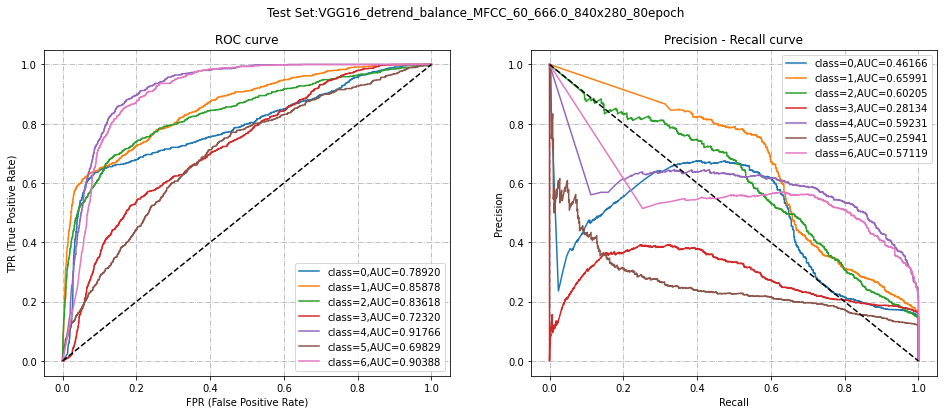

In [ ]:
"""4.2绘制ROC"""
plt.figure(figsize=(16,6))
plt.suptitle(f"Test Set:{model_name}")
def plot_multi_calss_ROC_curve(y_true_one_hot,y_pred_scores,class_num=7):
  # plt.figure(figsize=(8,6))
  plt.subplot(1,2,1)
  for class_no in range(class_num):
    y_true=y_true_one_hot[:,class_no]
    y_scores=y_pred_scores[:,class_no]
    fpr, tpr, thresholds = metrics.roc_curve((y_true), y_scores)
    AUC_ROC = metrics.roc_auc_score(y_true, y_scores)
    # test_integral = np.trapz(tpr,fpr) #trapz is numpy integration
    print (f"class_no={class_no}:Area under the ROC curve: {AUC_ROC}")
    plt.plot(fpr,tpr,'-',label=f"class={class_no},AUC={AUC_ROC:.5f}")
  
  plt.plot([0,1],[0,1],'k--')
  plt.title('ROC curve')
  plt.xlabel("FPR (False Positive Rate)")
  plt.ylabel("TPR (True Positive Rate)")
  plt.legend(loc="lower right")
  plt.grid(which="major", axis='both', linestyle='-.')
#     plt.savefig(path_experiment+"ROC.png")

def plot_multi_calss_PR_curve(y_true_one_hot,y_pred_scores,class_num=7):
  # plt.figure(figsize=(8,6))
  plt.subplot(1,2,2)
  for class_no in range(class_num):
    #Precision-recall curve
    y_true=y_true_one_hot[:,class_no]
    y_scores=y_pred_scores[:,class_no]

    precision, recall, thresholds = metrics.precision_recall_curve(y_true, y_scores)
    precision = np.fliplr([precision])[0]  #so the array is increasing (you won't get negative AUC)
    recall = np.fliplr([recall])[0]  #so the array is increasing (you won't get negative AUC)
    # 加入 （0，1），（1，0）点
    recall = np.append(recall,1)
    precision = np.append(precision,0)
    AUC_prec_rec = np.trapz(precision,recall)
    print (f"class_no={class_no}:Area under the PR curve: {AUC_prec_rec}")
    plt.plot(recall,precision,'-',label=f"class={class_no},AUC={AUC_prec_rec:.5f}")

  plt.plot([0,1],[1,0],'k--')
  plt.title('Precision - Recall curve')
  plt.xlabel("Recall")
  plt.ylabel("Precision")
  plt.legend(loc="best")
  plt.grid(which="major", axis='both', linestyle='-.')
#     plt.savefig(path_experiment+"Precision_recall.png")



y_truth_one_hot_result = np.array(tf.one_hot(y_truth_array, depth=7),dtype=int)
print(y_truth_one_hot_result[:3,])
plot_multi_calss_ROC_curve(y_true_one_hot=y_truth_one_hot_result,y_pred_scores=y_pred_score_result)
plot_multi_calss_PR_curve(y_true_one_hot=y_truth_one_hot_result,y_pred_scores=y_pred_score_result)


In [ ]:
model.summary()

# Two-stream 模型预测
## 使用 DataGenerator 方式测试(分片为单位）

In [53]:
batch_size=300
# validate_generator = DataGenerator(x_validate_freq,y_validate,x_validate_time, batch_size=batch_size,feature_save_dir_path=fbank_save_dir.as_posix())
validate_generator = DataGenerator(x_test_path_list,y_test,x_test_time, batch_size=batch_size,feature_save_dir_path=fbank_save_dir.as_posix())

y_truth_list =[]
y_pred_score_result = []
for index in range(validate_generator.__len__()):
  x_test_tmp, y = validate_generator.__getitem__(index)
  y_pred_score = model.predict(x_test_tmp)
  y_truth_list.extend(y.tolist())
  y_pred_score_result.extend(y_pred_score.tolist())

y_truth_list = np.array(y_truth_list)
y_pred_score_result = np.array(y_pred_score_result)

In [ ]:
print(y_pred_score_result.shape,y_truth_list.shape)

(3712, 7) (3712, 1)


test set: Y_TEST shape=(3712, 1)
y_pred_result=[1.96583301e-07 1.30345924e-07 1.50714863e-09 3.67486537e-01
 2.32406091e-02 3.98011785e-03 6.05292380e-01], shape=(3712, 7)
Confusion Matrix=[[437  44   0   0   0  60   4]
 [ 94 403   2   6   5  29   6]
 [  8   0 278   0   2  39 218]
 [  3  67   0  48 228  99 100]
 [  0   2   8  25 461  27  22]
 [  0   0 114  35  83 154  56]
 [ 16   7  27   3  30  48 414]]


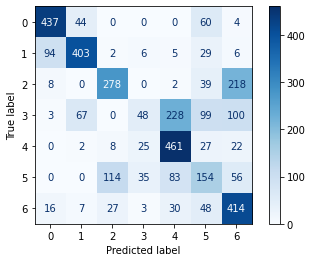

In [54]:
# 测试
from sklearn import metrics  # 画混淆矩阵
from sklearn.preprocessing import label_binarize  # 二值化类标》多分类化为2分类
from sklearn.metrics import plot_precision_recall_curve  # 画PR曲线
TEST_DATA_NAME="test set"
Y_TEST_array=y_truth_list
print(f"{TEST_DATA_NAME}: Y_TEST shape={Y_TEST_array.shape}")
print(f"y_pred_result={y_pred_score_result[0,:]}, shape={y_pred_score_result.shape}")

y_pred_class_result = np.argmax(y_pred_score_result, axis=1)
assert len(Y_TEST_array.shape)==2 and Y_TEST_array.shape[1]==1,"Y_TEST_array shape error!"
y_truth_array = np.reshape(Y_TEST_array[:,],(Y_TEST_array.shape[0]))

# 画混淆矩阵
def plot_confusion_matrix(y_pred,y_truth,model_name,class_num=7,cmap='viridis'):
  cm = metrics.confusion_matrix(y_truth,y_pred)
  print(f"Confusion Matrix={cm}")
  disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=np.arange(0,class_num,1))
  disp.plot(include_values=True,cmap=cmap, ax=None, xticks_rotation='horizontal',
                     values_format=None, colorbar=True)

plot_confusion_matrix(y_pred_class_result, y_truth_array,model_name,cmap=plt.cm.Blues)

In [55]:
def Metrics_Accuracy_etc(y_test, y_test_pred,class_num=7):
    # 1.Accuracy
    print("Accuracy:", metrics.accuracy_score(y_test, y_test_pred))
    # 2.Precision
    print("Precision")
    Precision_list = metrics.precision_score(y_test, y_test_pred, average=None)  # average参数=None，多分类时返回每个类的precision
    for i in range(class_num):
        print("class{}'s Precision={}".format(i, Precision_list[i]))
    print("Macro Precision=", metrics.precision_score(y_test, y_test_pred, average='macro'))  # 宏Precision 取平均

    # 3.Recall
    print("Recall")
    Recall_list = metrics.recall_score(y_test, y_test_pred, average=None)
    for i in range(class_num):  
        print("class{}'s Recall={}".format(i, Recall_list[i]))
    print("Macro Recall=", metrics.recall_score(y_test, y_test_pred, average='macro'))  # 宏Precision 取平均

    # 4.F1_score
    print("F1-score")
    F1_list = metrics.f1_score(y_test, y_test_pred, average=None)
    for i in range(class_num): 
        print("class{}'s F1-score={}".format(i, F1_list[i]))
    print("Macro F1-score=", metrics.f1_score(y_test, y_test_pred, average='macro'))  # 宏Precision 取平均

    # 5.Jaccard_score 判断相似度
    # 多分类》》视为2分类
    print("Jaccard系数（分析相似度）")
    Jaccard_list = metrics.jaccard_score(y_test, y_test_pred, average=None)
    for i in range(class_num):  
        print("class{}'s Jaccard={}".format(i, Jaccard_list[i]))
    print("Macro Jaccard=", metrics.jaccard_score(y_test, y_test_pred, average='macro'))  # 宏Precision 取平均
    plt.show()
Metrics_Accuracy_etc(y_truth_array,y_pred_class_result)

Accuracy: 0.5913254310344828
Precision
class0's Precision=0.7831541218637993
class1's Precision=0.7705544933078394
class2's Precision=0.6480186480186481
class3's Precision=0.41025641025641024
class4's Precision=0.5698393077873919
class5's Precision=0.33771929824561403
class6's Precision=0.5048780487804878
Macro Precision= 0.5749171897514558
Recall
class0's Recall=0.8018348623853211
class1's Recall=0.7394495412844037
class2's Recall=0.5100917431192661
class3's Recall=0.08807339449541285
class4's Recall=0.8458715596330275
class5's Recall=0.34841628959276016
class6's Recall=0.7596330275229358
Macro Recall= 0.5847672025761611
F1-score
class0's F1-score=0.7923844061650045
class1's F1-score=0.7546816479400749
class2's F1-score=0.5708418891170431
class3's F1-score=0.14501510574018128
class4's F1-score=0.6809453471196456
class5's F1-score=0.3429844097995546
class6's F1-score=0.6065934065934065
Macro F1-score= 0.5562066017821301
Jaccard系数（分析相似度）
class0's Jaccard=0.6561561561561562
class1's Jacc

[[0 0 0 1 0 0 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 1 0 0]]
class_no=0:Area under the ROC curve: 0.9779894728608963
class_no=1:Area under the ROC curve: 0.9685188135676689
class_no=2:Area under the ROC curve: 0.8951779098095903
class_no=3:Area under the ROC curve: 0.7665599661648363
class_no=4:Area under the ROC curve: 0.95163744231655
class_no=5:Area under the ROC curve: 0.7113585730693124
class_no=6:Area under the ROC curve: 0.9057496603447827
(4201,) (4201,) [0.00000000e+00 8.97988506e-05 2.24497126e-04 ... 9.44055316e-01
 9.44055316e-01 1.00000000e+00] [0.         0.04256466 0.05630388 ... 0.9997306  1.         1.        ]
macro roc:Area under the ROC curve: 0.9057496603447827
class_no=0:Area under the PR curve: 0.885181675022518
class_no=1:Area under the PR curve: 0.854811470360238
class_no=2:Area under the PR curve: 0.6052432609369661
class_no=3:Area under the PR curve: 0.304135368667652
class_no=4:Area under the PR curve: 0.7523403139452505
class_no=5:Area under the PR curve: 0.25763772

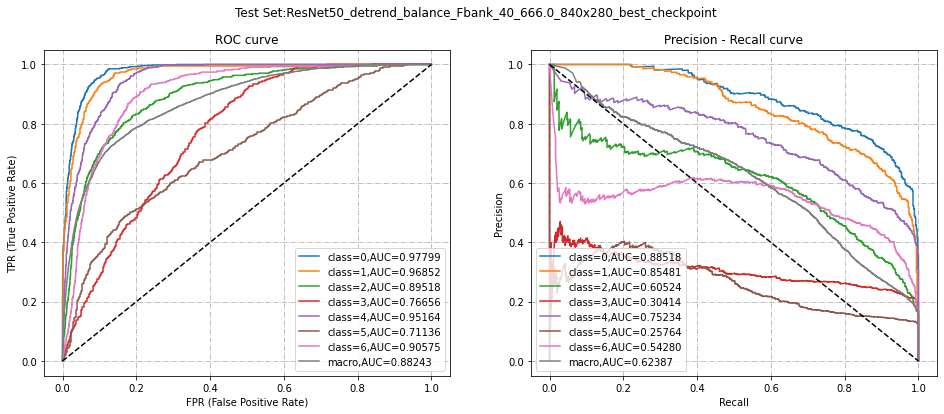

In [56]:
"""4.2绘制ROC"""
plt.figure(figsize=(16,6))
plt.suptitle(f"Test Set:{model_name}")
def plot_multi_calss_ROC_curve(y_true_one_hot,y_pred_scores,class_num=7):
  # plt.figure(figsize=(8,6))
  plt.subplot(1,2,1)
  for class_no in range(class_num):
    y_true=y_true_one_hot[:,class_no]
    y_scores=y_pred_scores[:,class_no]
    fpr, tpr, thresholds = metrics.roc_curve((y_true), y_scores)
    AUC_ROC = metrics.roc_auc_score(y_true, y_scores)
    # test_integral = np.trapz(tpr,fpr) #trapz is numpy integration
    print (f"class_no={class_no}:Area under the ROC curve: {AUC_ROC}")
    plt.plot(fpr,tpr,'-',label=f"class={class_no},AUC={AUC_ROC:.5f}")
  
  # 绘制 macro-roc
  fpr_macro, tpr_macro, thresholds = metrics.roc_curve((y_true_one_hot.ravel()), y_pred_scores.ravel())
  AUC_ROC_macro = metrics.roc_auc_score(y_true_one_hot, y_pred_scores)
  # test_integral = np.trapz(tpr,fpr) #trapz is numpy integration
  print(fpr_macro.shape, tpr_macro.shape, fpr_macro, tpr_macro)
  print (f"macro roc:Area under the ROC curve: {AUC_ROC}")
  plt.plot(fpr_macro,tpr_macro,'-',label=f"macro,AUC={AUC_ROC_macro:.5f}")
  
  plt.plot([0,1],[0,1],'k--')
  plt.title('ROC curve')
  plt.xlabel("FPR (False Positive Rate)")
  plt.ylabel("TPR (True Positive Rate)")
  plt.legend(loc="lower right")
  plt.grid(which="major", axis='both', linestyle='-.')
#     plt.savefig(path_experiment+"ROC.png")

def plot_multi_calss_PR_curve(y_true_one_hot,y_pred_scores,class_num=7):
  # plt.figure(figsize=(8,6))
  plt.subplot(1,2,2)
  for class_no in range(class_num):
    #Precision-recall curve
    y_true=y_true_one_hot[:,class_no]
    y_scores=y_pred_scores[:,class_no]

    precision, recall, thresholds = metrics.precision_recall_curve(y_true, y_scores)
    precision = np.fliplr([precision])[0]  #so the array is increasing (you won't get negative AUC)
    recall = np.fliplr([recall])[0]  #so the array is increasing (you won't get negative AUC)
    # 加入 （0，1），（1，0）点
    recall = np.append(recall,1)
    precision = np.append(precision,0)
    AUC_prec_rec = np.trapz(precision,recall)
    print (f"class_no={class_no}:Area under the PR curve: {AUC_prec_rec}")
    plt.plot(recall,precision,'-',label=f"class={class_no},AUC={AUC_prec_rec:.5f}")
  
  # 绘制 macro-pr
  precision_macro, recall_macro, thresholds = metrics.precision_recall_curve((y_true_one_hot.ravel()), y_pred_scores.ravel())
  precision_macro = np.fliplr([precision_macro])[0]  #so the array is increasing (you won't get negative AUC)
  recall_macro = np.fliplr([recall_macro])[0]  #so the array is increasing (you won't get negative AUC)
  # 加入 （0，1），（1，0）点
  recall_macro = np.append(recall_macro,1)
  precision_macro = np.append(precision_macro,0)
  AUC_pr_macro_rec = np.trapz(precision_macro,recall_macro)
  print (f"macro roc:Area under the PR curve: {AUC_pr_macro_rec}")
  plt.plot(recall_macro,precision_macro,'-',label=f"macro,AUC={AUC_pr_macro_rec:.5f}")

  plt.plot([0,1],[1,0],'k--')
  plt.title('Precision - Recall curve')
  plt.xlabel("Recall")
  plt.ylabel("Precision")
  plt.legend(loc="best")
  plt.grid(which="major", axis='both', linestyle='-.')
#     plt.savefig(path_experiment+"Precision_recall.png")


y_truth_one_hot_result = np.array(tf.one_hot(y_truth_array, depth=7),dtype=int)
print(y_truth_one_hot_result[:3,])
plot_multi_calss_ROC_curve(y_true_one_hot=y_truth_one_hot_result,y_pred_scores=y_pred_score_result)
plot_multi_calss_PR_curve(y_true_one_hot=y_truth_one_hot_result,y_pred_scores=y_pred_score_result)


### Comparision: barely macro-ROC, macro-PR curve

[[0 0 0 1 0 0 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 1 0 0]]
(4201,) (4201,)
class_no=macro:Area under the ROC curve: 0.8824274054476625
macro roc:Area under the PR curve: 0.6238661612095883
保存 roc-pr 数据成功:save_path=/content/drive/MyDrive/Pulse_7_Classification/model/roc_pr_ResNet50_detrend_balance_Fbank_40_666.0_840x280_best_checkpoint_slice


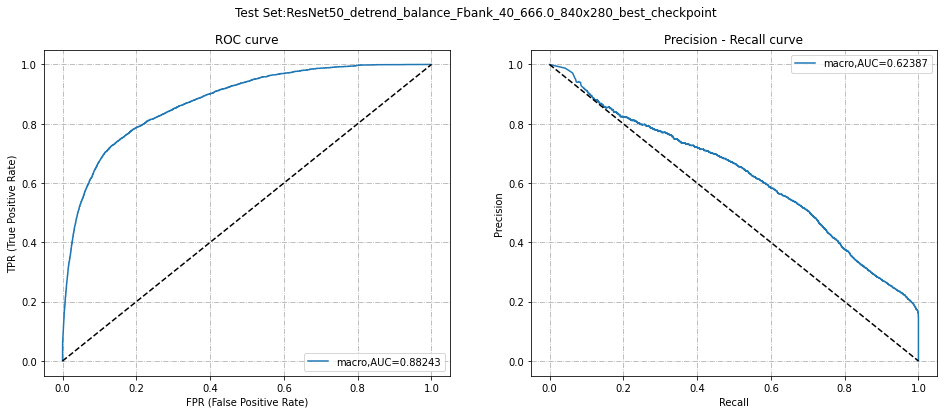

In [57]:
plt.figure(figsize=(16,6))
plt.suptitle(f"Test Set:{model_name}")
def plot_macro_roc_curve(y_true_one_hot,y_pred_scores):
  class_no='macro'
  fpr_macro, tpr_macro, thresholds = metrics.roc_curve((y_true_one_hot.ravel()), y_pred_scores.ravel())
  AUC_ROC_macro = metrics.roc_auc_score(y_true_one_hot, y_pred_scores)
  # test_integral = np.trapz(tpr,fpr) #trapz is numpy integration
  print(fpr_macro.shape, tpr_macro.shape)
  print (f"class_no={class_no}:Area under the ROC curve: {AUC_ROC_macro}")
  plt.subplot(1,2,1)
  plt.plot(fpr_macro,tpr_macro,'-',label=f"macro,AUC={AUC_ROC_macro:.5f}")

  plt.plot([0,1],[0,1],'k--')
  plt.title('ROC curve')
  plt.xlabel("FPR (False Positive Rate)")
  plt.ylabel("TPR (True Positive Rate)")
  plt.legend(loc="lower right")
  plt.grid(which="major", axis='both', linestyle='-.')

  # 绘制 macro-pr
  plt.subplot(1,2,2)
  precision_macro, recall_macro, thresholds = metrics.precision_recall_curve((y_true_one_hot.ravel()), y_pred_scores.ravel())
  precision_macro = np.fliplr([precision_macro])[0]  #so the array is increasing (you won't get negative AUC)
  recall_macro = np.fliplr([recall_macro])[0]  #so the array is increasing (you won't get negative AUC)
  # 加入 （0，1），（1，0）点
  recall_macro = np.append(recall_macro,1)
  precision_macro = np.append(precision_macro,0)
  AUC_pr_macro_rec = np.trapz(precision_macro,recall_macro)
  print (f"macro roc:Area under the PR curve: {AUC_pr_macro_rec}")
  plt.plot(recall_macro,precision_macro,'-',label=f"macro,AUC={AUC_pr_macro_rec:.5f}")
  plt.plot([0,1],[1,0],'k--')
  plt.title('Precision - Recall curve')
  plt.xlabel("Recall")
  plt.ylabel("Precision")
  plt.legend(loc="best")
  plt.grid(which="major", axis='both', linestyle='-.')

  # 保存模型的 macro_fpr, macro_tpr, macro_recall, macro_precision
  save_path = model_save_dir.joinpath(f"roc_pr_{model_name}_slice").as_posix()
  data={"fpr":fpr_macro,"tpr": tpr_macro, "precision":precision_macro, "recall":recall_macro,
        "AUC_roc_macro":AUC_ROC_macro,"AUC_pr_macro":AUC_pr_macro_rec}
  np.savez(save_path,data=data)
  print(f"保存 roc-pr 数据成功:save_path={save_path}")


y_truth_one_hot_result = np.array(tf.one_hot(y_truth_array, depth=7),dtype=int)
print(y_truth_one_hot_result[:3,])
plot_macro_roc_curve(y_true_one_hot=y_truth_one_hot_result,y_pred_scores=y_pred_score_result)


## 不同模型比较 roc、pr

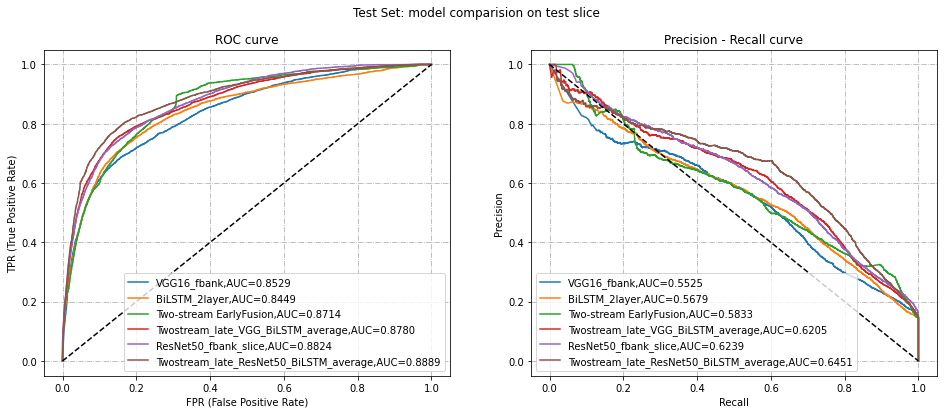

In [59]:
Inception10_result = np.load(model_save_dir.joinpath("roc_pr_Inception-10_detrend_balance_Fbank_120_666.0_840x280_best_checkpoint.npz"), allow_pickle=True)
Inception10_result = Inception10_result["data"].item()
VGG16_fbank_slice = np.load(model_save_dir.joinpath("roc_pr_VGG16_detrend_balance_Fbank_120_666.0_840x280_best_checkpoint_slice.npz"), allow_pickle=True)
VGG16_fbank_slice = VGG16_fbank_slice["data"].item()
BiLSTM_2layer_result = np.load(model_save_dir.joinpath("roc_pr_BiLSTM-2layer_detrend_balance_TimeDomain_100_666.0_2400x350_best_checkpoint_slice.npz"), allow_pickle=True)
BiLSTM_2layer_result = BiLSTM_2layer_result["data"].item()
Twostream_early_fusion = np.load(model_save_dir.joinpath("roc_pr_Two-stream-early-fusion_Unfreeze_detrend_balance_Fbank_25_666.0_2400x350_best_checkpoint_slice.npz"), allow_pickle=True)
Twostream_early_fusion = Twostream_early_fusion["data"].item()
Twostream_late_average = np.load(model_save_dir.joinpath("roc_pr_Two_stream_late_average_slice.npz"), allow_pickle=True)
Twostream_late_average = Twostream_late_average["data"].item()
Twostream_late_maximum = np.load(model_save_dir.joinpath("roc_pr_Two_stream_late_maximum_slice.npz"), allow_pickle=True)
Twostream_late_maximum = Twostream_late_maximum["data"].item()
ResNet50_fbank_slice = np.load(model_save_dir.joinpath("roc_pr_ResNet50_detrend_balance_Fbank_40_666.0_840x280_best_checkpoint_slice.npz"), allow_pickle=True)
ResNet50_fbank_slice = ResNet50_fbank_slice["data"].item()
Twostream_late_ResNet50_BiLSTM_average = np.load(model_save_dir.joinpath("roc_pr_Two_stream_late_average_Res50_BiLSTM_slice.npz"), allow_pickle=True)
Twostream_late_ResNet50_BiLSTM_average = Twostream_late_ResNet50_BiLSTM_average["data"].item()

plt.figure(figsize=(16,6))
plt.suptitle(f"Test Set: model comparision on test slice")
# 1. ROC curve
plt.subplot(1,2,1)
# plt.plot(Inception10_result["fpr"],Inception10_result["tpr"], label=f"InceptionNet10,AUC={Inception10_result['AUC_roc_macro']:.4f}")
plt.plot(VGG16_fbank_slice["fpr"],VGG16_fbank_slice["tpr"], label=f"VGG16_fbank,AUC={VGG16_fbank_slice['AUC_roc_macro']:.4f}")
plt.plot(BiLSTM_2layer_result["fpr"], BiLSTM_2layer_result["tpr"], label=f"BiLSTM_2layer,AUC={BiLSTM_2layer_result['AUC_roc_macro']:.4f}")
plt.plot(Twostream_early_fusion["fpr"],Twostream_early_fusion["tpr"], label=f"Two-stream EarlyFusion,AUC={Twostream_early_fusion['AUC_roc_macro']:.4f}")
plt.plot(Twostream_late_average["fpr"],Twostream_late_average["tpr"], label=f"Twostream_late_VGG_BiLSTM_average,AUC={Twostream_late_average['AUC_roc_macro']:.4f}")
plt.plot(ResNet50_fbank_slice["fpr"],ResNet50_fbank_slice["tpr"], label=f"ResNet50_fbank_slice,AUC={ResNet50_fbank_slice['AUC_roc_macro']:.4f}")
# plt.plot(Twostream_late_maximum["fpr"],Twostream_late_maximum["tpr"], label=f"Twostream_late_maximum,AUC={Twostream_late_maximum['AUC_roc_macro']:.4f}")
plt.plot(Twostream_late_ResNet50_BiLSTM_average["fpr"],Twostream_late_ResNet50_BiLSTM_average["tpr"], label=f"Twostream_late_ResNet50_BiLSTM_average,AUC={Twostream_late_ResNet50_BiLSTM_average['AUC_roc_macro']:.4f}")
plt.plot([0,1],[0,1],'k--')
plt.title('ROC curve')
plt.xlabel("FPR (False Positive Rate)")
plt.ylabel("TPR (True Positive Rate)")
plt.legend(loc="lower right")
plt.grid(which="major", axis='both', linestyle='-.')

# 2. PR curve
plt.subplot(1,2,2)
# plt.plot(Inception10_result["recall"],Inception10_result["precision"], label=f"InceptionNet10,AUC={Inception10_result['AUC_pr_macro']:.4f}")
plt.plot(VGG16_fbank_slice["recall"],VGG16_fbank_slice["precision"], label=f"VGG16_fbank,AUC={VGG16_fbank_slice['AUC_pr_macro']:.4f}")
plt.plot(BiLSTM_2layer_result["recall"], BiLSTM_2layer_result["precision"], label=f"BiLSTM_2layer,AUC={BiLSTM_2layer_result['AUC_pr_macro']:.4f}")
plt.plot(Twostream_early_fusion["recall"],Twostream_early_fusion["precision"], label=f"Two-stream EarlyFusion,AUC={Twostream_early_fusion['AUC_pr_macro']:.4f}")
plt.plot(Twostream_late_average["recall"],Twostream_late_average["precision"], label=f"Twostream_late_VGG_BiLSTM_average,AUC={Twostream_late_average['AUC_pr_macro']:.4f}")
# plt.plot(Twostream_late_maximum["recall"],Twostream_late_maximum["precision"], label=f"Twostream_late_maximum,AUC={Twostream_late_maximum['AUC_pr_macro']:.4f}")
plt.plot(ResNet50_fbank_slice["recall"],ResNet50_fbank_slice["precision"], label=f"ResNet50_fbank_slice,AUC={ResNet50_fbank_slice['AUC_pr_macro']:.4f}")
plt.plot(Twostream_late_ResNet50_BiLSTM_average["recall"],Twostream_late_ResNet50_BiLSTM_average["precision"], label=f"Twostream_late_ResNet50_BiLSTM_average,AUC={Twostream_late_ResNet50_BiLSTM_average['AUC_pr_macro']:.4f}")
plt.plot([0,1],[1,0],'k--')
plt.title('Precision - Recall curve')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="best")
plt.grid(which="major", axis='both', linestyle='-.')

# 以完整样本为单位预测

In [30]:
pulse_preprocess = PulsePreprocessing()
pulse_feature = PulseFeature()

# 降采样数据
downsampled_npz_filename = "downsampled_train_test_dict.npz"
sample_rate = 666.0  # 统一的采样率
npz_save_path_str = pulse_dataset_dir.joinpath(downsampled_npz_filename).as_posix()
assert Path(npz_save_path_str).is_file(), f"文件不存在, filepath={npz_save_path_str}"
pulse_all_class_data_dict = pulse_preprocess.load_npy_saved_pulse_data(npz_save_path=npz_save_path_str)

# 去基线漂移+去噪
start_time = time.time()
pulse_all_class_data_dict = pulse_preprocess.detrend_wave_data(pulse_all_class_data_dict)
print(f"去噪+去基线漂移完成！costs={time.time() - start_time}s")

# 测试数据: 取出完整样本预测
x_test = []
y_test = []
for class_no in pulse_all_class_data_dict:
    data_type = "test"
    for data_info_dict in pulse_all_class_data_dict[class_no][data_type]:
        x_test.append(data_info_dict["data"][0, :])
        y_test.append(class_no)
x_test_list = x_test  # 长度可能不一致！
y_test = np.array([y_test]).T

class_no=2 去基线漂移完成！
class_no=1 去基线漂移完成！
class_no=5 去基线漂移完成！
class_no=6 去基线漂移完成！
class_no=0 去基线漂移完成！
class_no=4 去基线漂移完成！
class_no=3 去基线漂移完成！
去噪+去基线漂移完成！costs=1.6961565017700195s


In [31]:
print(f"x_test_list len={len(x_test_list)} y_test shape={y_test.shape}")
print(f"x_test[0] shape={x_test_list[0].shape}")

# 查看测试集合各类分布
train_distribution_dict={class_no:np.sum(y_test==class_no) for class_no in pulse_all_class_data_dict}
print(f"y_test distribution:{train_distribution_dict}")

x_test_list len=35 y_test shape=(35, 1)
x_test[0] shape=(39960,)
y_test distribution:{2: 5, 1: 5, 5: 5, 6: 5, 0: 5, 4: 5, 3: 5}


In [ ]:
def show_x_test_wave(wave_data):
  plt.figure(figsize=(20,5))
  plt.plot(wave_data[:],'b-')

  plt.show()
show_x_test_wave(wave_data=x_test_list[29])

### Two-stream model

In [32]:
class TwoStreamEarlyFusionPredict:
    def __init__(self, pulse_feature_instance: PulseFeature, two_stream_model: Model,
                 feature_sample_rate=666, freq_frame_info=(840, 280), time_frame_info=(2400, 350, 40),
                 uniform_sample_num=10, freq_feature_choice="MFCC"):
        self.pulse_feature = pulse_feature_instance
        self.sample_rate = feature_sample_rate
        self.uniform_sample_num = uniform_sample_num
        assert freq_feature_choice in ["MFCC", "Fbank"], f"freq_feature_choice={freq_feature_choice} ERROR!"
        self.freq_feature_choice = True if freq_feature_choice == "MFCC" else False  # True->MFCC, False->Fbank

        # 分片信息
        self.freq_frame_length = freq_frame_info[0]  # 频域模型使用的分片大小
        self.freq_frame_step = freq_frame_info[1]
        self.time_frame_length = time_frame_info[0]
        self.time_frame_step = time_frame_info[1]
        self.RNN_time_step = time_frame_info[2]
        assert self.time_frame_length % self.RNN_time_step == 0, f"RNN input shape error!"
        self.RNN_feature_num_each_input = int(self.time_frame_length / self.RNN_time_step)

        self.two_stream_model = two_stream_model

    @staticmethod
    def get_data_slice(wave_data_array, frame_length, frame_step):
        assert isinstance(wave_data_array, np.ndarray) and len(wave_data_array.shape) == 1, f"wave data shape error!"

        signal_length = len(wave_data_array)
        num_frames = int(
            np.ceil(np.abs(signal_length - frame_length) / frame_step)) + 1
        pad_signal_length = (num_frames - 1) * frame_step + frame_length
        z = np.zeros((pad_signal_length - signal_length))
        # 分帧后最后一帧点数不足，则补零
        # 获取帧：frames 是二维数组，每一行是一帧，列数是每帧的采样点数，之后的短时 fft 直接在每一列上操作
        pad_signal = np.append(wave_data_array, z)
        indices = np.arange(0, frame_length).reshape(
            1, -1) + np.arange(0, num_frames * frame_step, frame_step).reshape(-1, 1)
        frames = pad_signal[indices]
        return frames

    def batch_sample_predict(self, x_test_list: List[np.ndarray], numcep_mfcc=20) -> np.ndarray:
        """
        对每个原始样本预测
        :param x_test_list: 原始波形样本，长度可能不一致！
        :param numcep_mfcc:
        :return: y_sample_predict_score_result
        """
        assert len(x_test_list[0].shape) == 1, f"x_test_list element_array shape error!"
        y_sample_predict_result = []
        for index in range(len(x_test_list)):
            x_data = x_test_list[index]
            print(f"x_data shape={x_data.shape}")
            # 0. 时域分片 1x2400
            x_data_frames = self.get_data_slice(wave_data_array=x_data,
                                                frame_length=self.time_frame_length, frame_step=self.time_frame_step)

            # 均匀取 n 帧 进行预测
            select_index_array = np.linspace(0, x_data_frames.shape[0], self.uniform_sample_num,
                                             endpoint=False, dtype=int)
            select_slice_array = x_data_frames[select_index_array, :]
            # print(f"select_index_array={select_index_array}, select_slice_array shape={select_slice_array.shape}")

            # 1. 频域时域输入特征转化
            # 时域
            time_data_array = np.reshape(select_slice_array, (select_slice_array.shape[0],
                                                              self.RNN_time_step, self.RNN_feature_num_each_input))
            # 频域
            freq_data_array = []
            for wave_data in select_slice_array:
                wave_data = np.reshape(wave_data[:self.freq_frame_length], (1, self.freq_frame_length))
                if self.freq_feature_choice:
                    freq_feature_matrix = self.pulse_feature.get_dynamic_mfcc_matrix(wave_data=wave_data,
                                                                                     sample_rate=self.sample_rate,
                                                                                     numcep=numcep_mfcc)
                else:
                    freq_feature_matrix = self.pulse_feature.get_fbank_matrix(wave_data=wave_data,
                                                                              sample_rate=sample_rate)
                freq_data_array.append(freq_feature_matrix)
            freq_data_array = np.array(freq_data_array)
            freq_data_array = np.reshape(freq_data_array, (*freq_data_array.shape, 1))
            print(f"freq_data_array.shape={freq_data_array.shape}")

            # 2. 对每个分片预测
            # # 0. 单独调用方式
            # freq_predict_scores = self.freq_model.predict(freq_data_array)
            # time_predict_scores = self.time_model.predict(time_data_array)
            # y_slices_predict_scores = (freq_predict_scores + time_predict_scores) / 2

            # 1. 模型融合
            y_slices_predict_scores = self.two_stream_model.predict([time_data_array, freq_data_array])

            y_sample_predict_scores = np.average(y_slices_predict_scores, axis=0)
            y_sample_predict_result.append(y_sample_predict_scores)
            print(
                f"index={index} y_sample_predict_scores={y_sample_predict_scores} shape={y_sample_predict_scores.shape}")
            # break

        return np.array(y_sample_predict_result)

    def predict_time_slice_2_stream(self, x_test_array: np.ndarray, numcep_mfcc=20) -> np.ndarray:
        """
        直接取分片好的 1x2400 大小分片数据，进行预测
        :param x_test_array: Nx2400
        :param numcep_mfcc:
        :return: y_sample_predict_scores -> Nx7
        """
        assert isinstance(x_test_array, np.ndarray) and len(x_test_array.shape) == 2, "x_test shape not match!"

        # 1. 频域时域输入特征转化
        # 时域
        time_data_array = np.reshape(x_test_array, (x_test_array.shape[0],
                                                    self.RNN_time_step, self.RNN_feature_num_each_input))
        # 频域
        freq_data_array = []
        for index in range(x_test_array.shape[0]):
            wave_data = x_test_array[index, :self.freq_frame_length]
            wave_data = np.reshape(wave_data, (1, -1))
            if self.freq_feature_choice:
                freq_feature_matrix = self.pulse_feature.get_dynamic_mfcc_matrix(wave_data=wave_data,
                                                                                 sample_rate=self.sample_rate,
                                                                                 numcep=numcep_mfcc)
            else:
                freq_feature_matrix = self.pulse_feature.get_fbank_matrix(wave_data=wave_data,
                                                                          sample_rate=sample_rate)
            freq_data_array.append(freq_feature_matrix)
        freq_data_array = np.array(freq_data_array)
        freq_data_array = np.reshape(freq_data_array, (*freq_data_array.shape, 1))
        print(f"freq_data_array.shape={freq_data_array.shape}")

        # two-stream model predict
        y_sample_predict_scores = self.two_stream_model.predict([time_data_array, freq_data_array])
        print(f"y_sample_predict_scores={y_sample_predict_scores} shape={y_sample_predict_scores.shape}")

        return y_sample_predict_scores




In [ ]:
# 对每个样本预测
from tensorflow.keras.models import load_model
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import concatenate, Add, Average, Maximum

model_save_dir=base_path.joinpath("model")
model_save_dir.mkdir(exist_ok=True, parents=True)

# 0. 加载模型
two_stream_model = model

# 1. 分片信息
_time_frame_info = (2400, 350, 40)  # frame_length, frame_step, RNN time step
_freq_frame_info = (840, 280)
numcep_mfcc = 20
freq_feature_choice_str = "Fbank"
assert _time_frame_info[0] % _time_frame_info[2] == 0, f"RNN input shape error!"
two_stream_predict = TwoStreamEarlyFusionPredict(pulse_feature_instance=pulse_feature,
                    two_stream_model=two_stream_model,
                    feature_sample_rate=666, freq_frame_info=_freq_frame_info,
                    time_frame_info=_time_frame_info,
                    uniform_sample_num=10, freq_feature_choice=freq_feature_choice_str)
y_pred_score_result = two_stream_predict.batch_sample_predict(x_test_list=x_test_list)

test set: Y_TEST shape=(35, 1)
y_pred_result=[8.4705614e-03 1.1361053e-02 2.8097087e-01 4.0786752e-08 8.2467182e-04
 1.0661541e-01 5.9175742e-01], shape=(35, 7)
Confusion Matrix=[[5 0 0 0 0 0 0]
 [0 5 0 0 0 0 0]
 [0 0 3 0 0 0 2]
 [0 0 0 0 3 2 0]
 [0 0 0 0 5 0 0]
 [0 0 1 0 1 2 1]
 [0 0 0 0 0 0 5]]


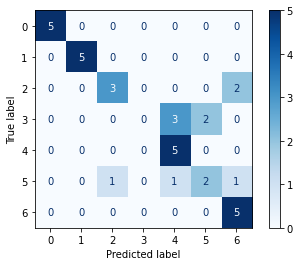

In [34]:
# 测试
from sklearn import metrics  # 画混淆矩阵
from sklearn.preprocessing import label_binarize  # 二值化类标》多分类化为2分类
from sklearn.metrics import plot_precision_recall_curve  # 画PR曲线
TEST_DATA_NAME="test set"
Y_TEST_array=y_test
print(f"{TEST_DATA_NAME}: Y_TEST shape={Y_TEST_array.shape}")
print(f"y_pred_result={y_pred_score_result[0,:]}, shape={y_pred_score_result.shape}")

y_pred_class_result = np.argmax(y_pred_score_result, axis=1)
assert len(Y_TEST_array.shape)==2 and Y_TEST_array.shape[1]==1,"Y_TEST_array shape error!"
y_truth_array = np.reshape(Y_TEST_array[:,],(Y_TEST_array.shape[0]))

# 画混淆矩阵
def plot_confusion_matrix(y_pred,y_truth,model_name,class_num=7,cmap='viridis'):
  cm = metrics.confusion_matrix(y_truth,y_pred)
  print(f"Confusion Matrix={cm}")
  disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=np.arange(0,class_num,1))
  disp.plot(include_values=True,cmap=cmap, ax=None, xticks_rotation='horizontal',
                     values_format=None, colorbar=True)

plot_confusion_matrix(y_pred_class_result, y_truth_array,model_name,cmap=plt.cm.Blues)

In [35]:
def Metrics_Accuracy_etc(y_test, y_test_pred,class_num=7):
    # 1.Accuracy
    print("Accuracy:", metrics.accuracy_score(y_test, y_test_pred))
    # 2.Precision
    print("Precision")
    Precision_list = metrics.precision_score(y_test, y_test_pred, average=None)  # average参数=None，多分类时返回每个类的precision
    for i in range(class_num):
        print("class{}'s Precision={}".format(i, Precision_list[i]))
    print("Macro Precision=", metrics.precision_score(y_test, y_test_pred, average='macro'))  # 宏Precision 取平均

    # 3.Recall
    print("Recall")
    Recall_list = metrics.recall_score(y_test, y_test_pred, average=None)
    for i in range(class_num):  
        print("class{}'s Recall={}".format(i, Recall_list[i]))
    print("Macro Recall=", metrics.recall_score(y_test, y_test_pred, average='macro'))  # 宏Precision 取平均

    # 4.F1_score
    print("F1-score")
    F1_list = metrics.f1_score(y_test, y_test_pred, average=None)
    for i in range(class_num): 
        print("class{}'s F1-score={}".format(i, F1_list[i]))
    print("Macro F1-score=", metrics.f1_score(y_test, y_test_pred, average='macro'))  # 宏Precision 取平均

    # 5.Jaccard_score 判断相似度
    # 多分类》》视为2分类
    print("Jaccard系数（分析相似度）")
    Jaccard_list = metrics.jaccard_score(y_test, y_test_pred, average=None)
    for i in range(class_num):  
        print("class{}'s Jaccard={}".format(i, Jaccard_list[i]))
    print("Macro Jaccard=", metrics.jaccard_score(y_test, y_test_pred, average='macro'))  # 宏Precision 取平均
    plt.show()
Metrics_Accuracy_etc(y_truth_array,y_pred_class_result)

Accuracy: 0.7142857142857143
Precision
class0's Precision=1.0
class1's Precision=1.0
class2's Precision=0.75
class3's Precision=0.0
class4's Precision=0.5555555555555556
class5's Precision=0.5
class6's Precision=0.625
Macro Precision= 0.6329365079365079
Recall
class0's Recall=1.0
class1's Recall=1.0
class2's Recall=0.6
class3's Recall=0.0
class4's Recall=1.0
class5's Recall=0.4
class6's Recall=1.0
Macro Recall= 0.7142857142857143
F1-score
class0's F1-score=1.0
class1's F1-score=1.0
class2's F1-score=0.6666666666666665
class3's F1-score=0.0
class4's F1-score=0.7142857142857143
class5's F1-score=0.4444444444444445
class6's F1-score=0.7692307692307693
Macro F1-score= 0.656375370661085
Jaccard系数（分析相似度）
class0's Jaccard=1.0
class1's Jaccard=1.0
class2's Jaccard=0.5
class3's Jaccard=0.0
class4's Jaccard=0.5555555555555556
class5's Jaccard=0.2857142857142857
class6's Jaccard=0.625
Macro Jaccard= 0.566609977324263


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 各类别下 roc+pr

[[0 0 1 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 1 0 0 0 0]]
class_no=0:Area under the ROC curve: 1.0
class_no=1:Area under the ROC curve: 1.0
class_no=2:Area under the ROC curve: 0.9600000000000001
class_no=3:Area under the ROC curve: 0.76
class_no=4:Area under the ROC curve: 0.9733333333333334
class_no=5:Area under the ROC curve: 0.7000000000000001
class_no=6:Area under the ROC curve: 0.9266666666666667
(36,) (36,) [0.         0.         0.         0.00952381 0.00952381 0.01428571
 0.01428571 0.01904762 0.01904762 0.02380952 0.02380952 0.03333333
 0.03333333 0.04285714 0.04285714 0.05238095 0.05238095 0.08571429
 0.08571429 0.0952381  0.0952381  0.16190476 0.16190476 0.26666667
 0.26666667 0.3        0.3        0.32380952 0.32380952 0.45714286
 0.45714286 0.46190476 0.46190476 0.48095238 0.48095238 1.        ] [0.         0.02857143 0.22857143 0.22857143 0.28571429 0.28571429
 0.34285714 0.34285714 0.45714286 0.45714286 0.57142857 0.57142857
 0.6        0.6        0.71428571 0.71428571 0.7428

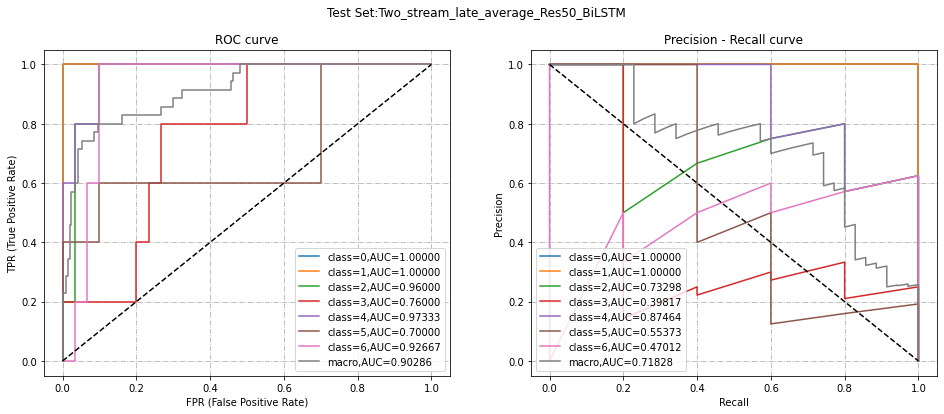

In [37]:
"""4.2绘制ROC"""
plt.figure(figsize=(16,6))
plt.suptitle(f"Test Set:{model_name}")
def plot_multi_calss_ROC_curve(y_true_one_hot,y_pred_scores,class_num=7):
  # plt.figure(figsize=(8,6))
  plt.subplot(1,2,1)
  for class_no in range(class_num):
    y_true=y_true_one_hot[:,class_no]
    y_scores=y_pred_scores[:,class_no]
    fpr, tpr, thresholds = metrics.roc_curve((y_true), y_scores)
    AUC_ROC = metrics.roc_auc_score(y_true, y_scores)
    # test_integral = np.trapz(tpr,fpr) #trapz is numpy integration
    print (f"class_no={class_no}:Area under the ROC curve: {AUC_ROC}")
    plt.plot(fpr,tpr,'-',label=f"class={class_no},AUC={AUC_ROC:.5f}")
  
  # 绘制 macro-roc
  fpr_macro, tpr_macro, thresholds = metrics.roc_curve((y_true_one_hot.ravel()), y_pred_scores.ravel())
  AUC_ROC_macro = metrics.roc_auc_score(y_true_one_hot, y_pred_scores)
  # test_integral = np.trapz(tpr,fpr) #trapz is numpy integration
  print(fpr_macro.shape, tpr_macro.shape, fpr_macro, tpr_macro)
  print (f"macro roc:Area under the ROC curve: {AUC_ROC}")
  plt.plot(fpr_macro,tpr_macro,'-',label=f"macro,AUC={AUC_ROC_macro:.5f}")
  
  plt.plot([0,1],[0,1],'k--')
  plt.title('ROC curve')
  plt.xlabel("FPR (False Positive Rate)")
  plt.ylabel("TPR (True Positive Rate)")
  plt.legend(loc="lower right")
  plt.grid(which="major", axis='both', linestyle='-.')
#     plt.savefig(path_experiment+"ROC.png")

def plot_multi_calss_PR_curve(y_true_one_hot,y_pred_scores,class_num=7):
  # plt.figure(figsize=(8,6))
  plt.subplot(1,2,2)
  for class_no in range(class_num):
    #Precision-recall curve
    y_true=y_true_one_hot[:,class_no]
    y_scores=y_pred_scores[:,class_no]

    precision, recall, thresholds = metrics.precision_recall_curve(y_true, y_scores)
    precision = np.fliplr([precision])[0]  #so the array is increasing (you won't get negative AUC)
    recall = np.fliplr([recall])[0]  #so the array is increasing (you won't get negative AUC)
    # 加入 （0，1），（1，0）点
    recall = np.append(recall,1)
    precision = np.append(precision,0)
    AUC_prec_rec = np.trapz(precision,recall)
    print (f"class_no={class_no}:Area under the PR curve: {AUC_prec_rec}")
    plt.plot(recall,precision,'-',label=f"class={class_no},AUC={AUC_prec_rec:.5f}")
  
  # 绘制 macro-pr
  precision_macro, recall_macro, thresholds = metrics.precision_recall_curve((y_true_one_hot.ravel()), y_pred_scores.ravel())
  precision_macro = np.fliplr([precision_macro])[0]  #so the array is increasing (you won't get negative AUC)
  recall_macro = np.fliplr([recall_macro])[0]  #so the array is increasing (you won't get negative AUC)
  # 加入 （0，1），（1，0）点
  recall_macro = np.append(recall_macro,1)
  precision_macro = np.append(precision_macro,0)
  AUC_pr_macro_rec = np.trapz(precision_macro,recall_macro)
  print (f"macro roc:Area under the PR curve: {AUC_pr_macro_rec}")
  plt.plot(recall_macro,precision_macro,'-',label=f"macro,AUC={AUC_pr_macro_rec:.5f}")

  plt.plot([0,1],[1,0],'k--')
  plt.title('Precision - Recall curve')
  plt.xlabel("Recall")
  plt.ylabel("Precision")
  plt.legend(loc="best")
  plt.grid(which="major", axis='both', linestyle='-.')
#     plt.savefig(path_experiment+"Precision_recall.png")


y_truth_one_hot_result = np.array(tf.one_hot(y_truth_array, depth=7),dtype=int)
print(y_truth_one_hot_result[:3,])
plot_multi_calss_ROC_curve(y_true_one_hot=y_truth_one_hot_result,y_pred_scores=y_pred_score_result)
plot_multi_calss_PR_curve(y_true_one_hot=y_truth_one_hot_result,y_pred_scores=y_pred_score_result)


### Comparision: barely macro-ROC, macro-PR curve

[[0 0 1 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 1 0 0 0 0]]
(36,) (36,)
class_no=macro:Area under the ROC curve: 0.9028571428571429
macro roc:Area under the PR curve: 0.7182760565719905
保存 roc-pr 数据成功:save_path=/content/drive/MyDrive/Pulse_7_Classification/model/roc_pr_Two_stream_late_average_Res50_BiLSTM_whole_sample


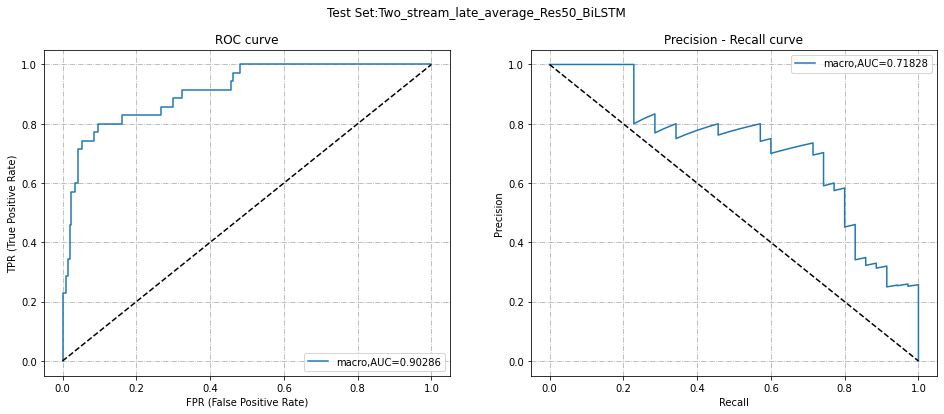

In [38]:
plt.figure(figsize=(16,6))
plt.suptitle(f"Test Set:{model_name}")
def plot_macro_roc_curve(y_true_one_hot,y_pred_scores):
  class_no='macro'
  fpr_macro, tpr_macro, thresholds = metrics.roc_curve((y_true_one_hot.ravel()), y_pred_scores.ravel())
  AUC_ROC_macro = metrics.roc_auc_score(y_true_one_hot, y_pred_scores)
  # test_integral = np.trapz(tpr,fpr) #trapz is numpy integration
  print(fpr_macro.shape, tpr_macro.shape)
  print (f"class_no={class_no}:Area under the ROC curve: {AUC_ROC_macro}")
  plt.subplot(1,2,1)
  plt.plot(fpr_macro,tpr_macro,'-',label=f"macro,AUC={AUC_ROC_macro:.5f}")

  plt.plot([0,1],[0,1],'k--')
  plt.title('ROC curve')
  plt.xlabel("FPR (False Positive Rate)")
  plt.ylabel("TPR (True Positive Rate)")
  plt.legend(loc="lower right")
  plt.grid(which="major", axis='both', linestyle='-.')

  # 绘制 macro-pr
  plt.subplot(1,2,2)
  precision_macro, recall_macro, thresholds = metrics.precision_recall_curve((y_true_one_hot.ravel()), y_pred_scores.ravel())
  precision_macro = np.fliplr([precision_macro])[0]  #so the array is increasing (you won't get negative AUC)
  recall_macro = np.fliplr([recall_macro])[0]  #so the array is increasing (you won't get negative AUC)
  # 加入 （0，1），（1，0）点
  recall_macro = np.append(recall_macro,1)
  precision_macro = np.append(precision_macro,0)
  AUC_pr_macro_rec = np.trapz(precision_macro,recall_macro)
  print (f"macro roc:Area under the PR curve: {AUC_pr_macro_rec}")
  plt.plot(recall_macro,precision_macro,'-',label=f"macro,AUC={AUC_pr_macro_rec:.5f}")
  plt.plot([0,1],[1,0],'k--')
  plt.title('Precision - Recall curve')
  plt.xlabel("Recall")
  plt.ylabel("Precision")
  plt.legend(loc="best")
  plt.grid(which="major", axis='both', linestyle='-.')

  # 保存模型的 macro_fpr, macro_tpr, macro_recall, macro_precision
  save_path = model_save_dir.joinpath(f"roc_pr_{model_name}_whole_sample").as_posix()
  data={"fpr":fpr_macro,"tpr": tpr_macro, "precision":precision_macro, "recall":recall_macro,
        "AUC_roc_macro":AUC_ROC_macro,"AUC_pr_macro":AUC_pr_macro_rec}
  np.savez(save_path,data=data)
  print(f"保存 roc-pr 数据成功:save_path={save_path}")


y_truth_one_hot_result = np.array(tf.one_hot(y_truth_array, depth=7),dtype=int)
print(y_truth_one_hot_result[:3,])
plot_macro_roc_curve(y_true_one_hot=y_truth_one_hot_result,y_pred_scores=y_pred_score_result)


## 不同模型比较 roc、pr

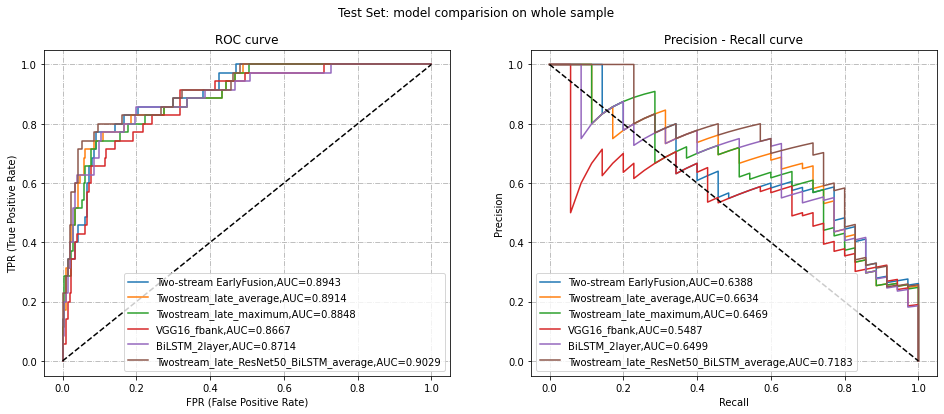

In [41]:
Inception10_result = np.load(model_save_dir.joinpath("roc_pr_Inception-10_detrend_balance_Fbank_120_666.0_840x280_best_checkpoint.npz"), allow_pickle=True)
Inception10_result = Inception10_result["data"].item()
VGG16_fbank_result = np.load(model_save_dir.joinpath("roc_pr_VGG16_detrend_balance_Fbank_120_666.0_840x280_best_checkpoint_whole_sample.npz"), allow_pickle=True)
VGG16_fbank_result = VGG16_fbank_result["data"].item()
BiLSTM_2layer_result = np.load(model_save_dir.joinpath("roc_pr_BiLSTM-2layer_detrend_balance_TimeDomain_100_666.0_2400x350_best_checkpoint_whole_sample.npz"), allow_pickle=True)
BiLSTM_2layer_result = BiLSTM_2layer_result["data"].item()
Twostream_early_fusion = np.load(model_save_dir.joinpath("roc_pr_Two-stream-early-fusion_Unfreeze_detrend_balance_Fbank_25_666.0_2400x350_best_checkpoint_whole_sample.npz"), allow_pickle=True)
Twostream_early_fusion = Twostream_early_fusion["data"].item()
Twostream_late_average = np.load(model_save_dir.joinpath("roc_pr_Two_stream_late_average_whole_sample.npz"), allow_pickle=True)
Twostream_late_average = Twostream_late_average["data"].item()
Twostream_late_maximum = np.load(model_save_dir.joinpath("roc_pr_Two_stream_late_maximum_whole_sample.npz"), allow_pickle=True)
Twostream_late_maximum = Twostream_late_maximum["data"].item()
Twostream_late_ResNet50_BiLSTM_average = np.load(model_save_dir.joinpath("roc_pr_Two_stream_late_average_Res50_BiLSTM_whole_sample.npz"), allow_pickle=True)
Twostream_late_ResNet50_BiLSTM_average = Twostream_late_ResNet50_BiLSTM_average["data"].item()

plt.figure(figsize=(16,6))
plt.suptitle(f"Test Set: model comparision on whole sample")
# 1. ROC curve
plt.subplot(1,2,1)
# plt.plot(Inception10_result["fpr"],Inception10_result["tpr"], label=f"InceptionNet10,AUC={Inception10_result['AUC_roc_macro']:.4f}")
plt.plot(Twostream_early_fusion["fpr"],Twostream_early_fusion["tpr"], label=f"Two-stream EarlyFusion,AUC={Twostream_early_fusion['AUC_roc_macro']:.4f}")
plt.plot(Twostream_late_average["fpr"],Twostream_late_average["tpr"], label=f"Twostream_late_average,AUC={Twostream_late_average['AUC_roc_macro']:.4f}")
plt.plot(Twostream_late_maximum["fpr"],Twostream_late_maximum["tpr"], label=f"Twostream_late_maximum,AUC={Twostream_late_maximum['AUC_roc_macro']:.4f}")
plt.plot(VGG16_fbank_result["fpr"],VGG16_fbank_result["tpr"], label=f"VGG16_fbank,AUC={VGG16_fbank_result['AUC_roc_macro']:.4f}")
plt.plot(BiLSTM_2layer_result["fpr"], BiLSTM_2layer_result["tpr"], label=f"BiLSTM_2layer,AUC={BiLSTM_2layer_result['AUC_roc_macro']:.4f}")
plt.plot(Twostream_late_ResNet50_BiLSTM_average["fpr"],Twostream_late_ResNet50_BiLSTM_average["tpr"], label=f"Twostream_late_ResNet50_BiLSTM_average,AUC={Twostream_late_ResNet50_BiLSTM_average['AUC_roc_macro']:.4f}")
plt.plot([0,1],[0,1],'k--')
plt.title('ROC curve')
plt.xlabel("FPR (False Positive Rate)")
plt.ylabel("TPR (True Positive Rate)")
plt.legend(loc="lower right")
plt.grid(which="major", axis='both', linestyle='-.')

# 2. PR curve
plt.subplot(1,2,2)
# plt.plot(Inception10_result["recall"],Inception10_result["precision"], label=f"InceptionNet10,AUC={Inception10_result['AUC_pr_macro']:.4f}")
plt.plot(Twostream_early_fusion["recall"],Twostream_early_fusion["precision"], label=f"Two-stream EarlyFusion,AUC={Twostream_early_fusion['AUC_pr_macro']:.4f}")
plt.plot(Twostream_late_average["recall"],Twostream_late_average["precision"], label=f"Twostream_late_average,AUC={Twostream_late_average['AUC_pr_macro']:.4f}")
plt.plot(Twostream_late_maximum["recall"],Twostream_late_maximum["precision"], label=f"Twostream_late_maximum,AUC={Twostream_late_maximum['AUC_pr_macro']:.4f}")
plt.plot(VGG16_fbank_result["recall"],VGG16_fbank_result["precision"], label=f"VGG16_fbank,AUC={VGG16_fbank_result['AUC_pr_macro']:.4f}")
plt.plot(BiLSTM_2layer_result["recall"], BiLSTM_2layer_result["precision"], label=f"BiLSTM_2layer,AUC={BiLSTM_2layer_result['AUC_pr_macro']:.4f}")
plt.plot(Twostream_late_ResNet50_BiLSTM_average["recall"], Twostream_late_ResNet50_BiLSTM_average["precision"], label=f"Twostream_late_ResNet50_BiLSTM_average,AUC={Twostream_late_ResNet50_BiLSTM_average['AUC_pr_macro']:.4f}")
plt.plot([0,1],[1,0],'k--')
plt.title('Precision - Recall curve')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="best")
plt.grid(which="major", axis='both', linestyle='-.')